In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor


In [2]:
df = pd.read_csv("D:/Git Hub IMP/Energy_consumption_forecasting/Energy-Consumption-Analysis/Data_Output/Final_Feature_Engineered_Data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

TARGET = "TARGET_Total_Electric_Load_kW"

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (187728, 34)


Date  PV_Generation_kW  Grid_Import_kW  \
0 2001-06-02 00:00:00               0.0           220.0   
1 2001-06-02 01:00:00               0.0           193.0   
2 2001-06-02 02:00:00               0.0           189.0   
3 2001-06-02 03:00:00               0.0           182.0   
4 2001-06-02 04:00:00               0.0           184.0   

   GasEngine_Generation_kW  FuelCell_Generation_kW  Electric_Load_A_kW  \
0                      0.0                   194.0               414.0   
1                      0.0                   174.0               367.0   
2                      0.0                   162.0               351.0   
3                      0.0                   151.0               333.0   
4                      0.0                   151.0               335.0   

   Cooling_Load_A_kW  Heating_Load_A_kW  HotWater_Load_A_kW  \
0                0.0                0.0                20.0   
1                0.0                0.0                21.0   
2                0.0                0.0                21.0   
3                0.0                0.0                22.0   
4                0.0                0.0                22.0   

   Solar_Irradiation_W  ...  DayOfWeek_cos  Wind_Direction_sin  \
0                  0.0  ...      -0.222521           -0.669131   
1                  0.0  ...      -0.222521           -0.484810   
2                  0.0  ...      -0.222521           -0.515038   
3                  0.0  ...      -0.222521           -0.469472   
4                  0.0  ...      -0.222521           -0.422618   

   Wind_Direction_cos  HDD  CDD  Temp_Stress_x_Hour  Is_Solar_Active  \
0           -0.743145  0.0  1.5                 0.0                0   
1           -0.874620  0.0  0.6                 0.6                0   
2           -0.857167  0.0  0.4                 0.8                0   
3           -0.882948  0.0  0.4                 1.2                0   
4           -0.906308  0.0  0.5                 2.0                0   

   Lag_24h_Load  EWMA_24h_Load  Is_Holiday  
0         886.0    1255.499994           0  
1         896.0    1216.442657           0  
2         834.0    1172.860823           0  
3         852.0    1130.760383           0  
4         858.0    1089.592848           0  

[5 rows x 34 columns]

In [3]:
df.isnull().sum()

Date                             0
PV_Generation_kW                 0
Grid_Import_kW                   0
GasEngine_Generation_kW          0
FuelCell_Generation_kW           0
Electric_Load_A_kW               0
Cooling_Load_A_kW                0
Heating_Load_A_kW                0
HotWater_Load_A_kW               0
Solar_Irradiation_W              0
Outdoor_Air_Temp_C               0
Outdoor_Air_Humidity_percent     0
Wind_Speed_ms                    0
Wind_Direction_deg               0
Electric_Load_B_kW               0
Gas1_Input_GJh                   0
Gas2_Input_GJh                   0
FuelCell1_Input_GJh              0
FuelCell2_Input_GJh              0
FuelCell3_Input_GJh              0
TARGET_Total_Electric_Load_kW    0
Hour_sin                         0
Hour_cos                         0
DayOfWeek_sin                    0
DayOfWeek_cos                    0
Wind_Direction_sin               0
Wind_Direction_cos               0
HDD                              0
CDD                 

In [4]:
df.columns

Index(['Date', 'PV_Generation_kW', 'Grid_Import_kW', 'GasEngine_Generation_kW',
       'FuelCell_Generation_kW', 'Electric_Load_A_kW', 'Cooling_Load_A_kW',
       'Heating_Load_A_kW', 'HotWater_Load_A_kW', 'Solar_Irradiation_W',
       'Outdoor_Air_Temp_C', 'Outdoor_Air_Humidity_percent', 'Wind_Speed_ms',
       'Wind_Direction_deg', 'Electric_Load_B_kW', 'Gas1_Input_GJh',
       'Gas2_Input_GJh', 'FuelCell1_Input_GJh', 'FuelCell2_Input_GJh',
       'FuelCell3_Input_GJh', 'TARGET_Total_Electric_Load_kW', 'Hour_sin',
       'Hour_cos', 'DayOfWeek_sin', 'DayOfWeek_cos', 'Wind_Direction_sin',
       'Wind_Direction_cos', 'HDD', 'CDD', 'Temp_Stress_x_Hour',
       'Is_Solar_Active', 'Lag_24h_Load', 'EWMA_24h_Load', 'Is_Holiday'],
      dtype='object')

In [5]:
df.dtypes

Date                             datetime64[ns]
PV_Generation_kW                        float64
Grid_Import_kW                          float64
GasEngine_Generation_kW                 float64
FuelCell_Generation_kW                  float64
Electric_Load_A_kW                      float64
Cooling_Load_A_kW                       float64
Heating_Load_A_kW                       float64
HotWater_Load_A_kW                      float64
Solar_Irradiation_W                     float64
Outdoor_Air_Temp_C                      float64
Outdoor_Air_Humidity_percent            float64
Wind_Speed_ms                           float64
Wind_Direction_deg                      float64
Electric_Load_B_kW                      float64
Gas1_Input_GJh                          float64
Gas2_Input_GJh                          float64
FuelCell1_Input_GJh                     float64
FuelCell2_Input_GJh                     float64
FuelCell3_Input_GJh                     float64
TARGET_Total_Electric_Load_kW           

In [6]:
df.describe().T

count                 mean  \
Date                             187728  2012-02-15 23:30:00   
PV_Generation_kW               187728.0            10.164205   
Grid_Import_kW                 187728.0           611.286209   
GasEngine_Generation_kW        187728.0            48.704041   
FuelCell_Generation_kW         187728.0            81.303525   
Electric_Load_A_kW             187728.0           751.452228   
Cooling_Load_A_kW              187728.0           207.383124   
Heating_Load_A_kW              187728.0           158.057894   
HotWater_Load_A_kW             187728.0            53.382034   
Solar_Irradiation_W            187728.0           145.015788   
Outdoor_Air_Temp_C             187728.0            17.079189   
Outdoor_Air_Humidity_percent   187728.0            67.168739   
Wind_Speed_ms                  187728.0             2.158601   
Wind_Direction_deg             187728.0           262.217999   
Electric_Load_B_kW             187728.0           751.452228   
Gas1_Input_GJh                 187728.0             0.142913   
Gas2_Input_GJh                 187728.0             0.275542   
FuelCell1_Input_GJh            187728.0             0.246139   
FuelCell2_Input_GJh            187728.0              0.10123   
FuelCell3_Input_GJh            187728.0             0.003619   
TARGET_Total_Electric_Load_kW  187728.0          1502.904455   
Hour_sin                       187728.0                 -0.0   
Hour_cos                       187728.0                 -0.0   
DayOfWeek_sin                  187728.0            -0.000225   
DayOfWeek_cos                  187728.0             0.000179   
Wind_Direction_sin             187728.0             0.109008   
Wind_Direction_cos             187728.0            -0.077165   
HDD                            187728.0             3.961451   
CDD                            187728.0             3.040639   
Temp_Stress_x_Hour             187728.0            79.992149   
Is_Solar_Active                187728.0             0.366248   
Lag_24h_Load                   187728.0          1502.904296   
EWMA_24h_Load                  187728.0          1502.906696   
Is_Holiday                     187728.0             0.030811   

                                               min                  25%  \
Date                           2001-06-02 00:00:00  2006-10-09 11:45:00   
PV_Generation_kW                               0.0                  0.0   
Grid_Import_kW                                63.0                434.0   
GasEngine_Generation_kW                        0.0                  0.0   
FuelCell_Generation_kW                         0.0                  0.0   
Electric_Load_A_kW                            63.0                527.0   
Cooling_Load_A_kW                              0.0                  0.0   
Heating_Load_A_kW                              0.0                  0.0   
HotWater_Load_A_kW                             0.0              50.2818   
Solar_Irradiation_W                            0.0                  0.0   
Outdoor_Air_Temp_C                            -3.8                 10.2   
Outdoor_Air_Humidity_percent                  11.0                 56.0   
Wind_Speed_ms                                  0.0                  1.0   
Wind_Direction_deg                             0.0                171.0   
Electric_Load_B_kW                            63.0                527.0   
Gas1_Input_GJh                                 0.0                  0.0   
Gas2_Input_GJh                                 0.0                  0.0   
FuelCell1_Input_GJh                            0.0                  0.0   
FuelCell2_Input_GJh                            0.0                  0.0   
FuelCell3_Input_GJh                            0.0                  0.0   
TARGET_Total_Electric_Load_kW                126.0               1054.0   
Hour_sin                                      -1.0            -0.707107   
Hour_cos                                      -1.0            -0.707

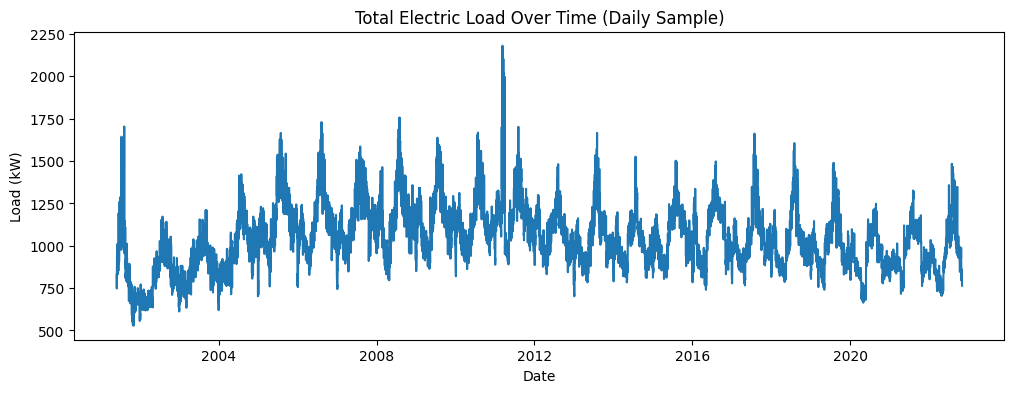

In [7]:
# Target over time (daily sample for speed)
plt.figure(figsize=(12,4))
plt.plot(df["Date"].iloc[::24], df[TARGET].iloc[::24])
plt.title("Total Electric Load Over Time (Daily Sample)")
plt.xlabel("Date")
plt.ylabel("Load (kW)")
plt.show()


The daily-sampled electric load graph shows clear yearly seasonal patterns, with demand rising and falling consistently across years. There are noticeable peaks likely caused by extreme weather or operational spikes, while the overall trend remains relatively stable with slight variations over time. Daily sampling smooths hourly noise, making long-term cycles easy to observe. These recurring seasonal patterns and occasional sharp peaks indicate that the energy system has strong nonlinear behavior

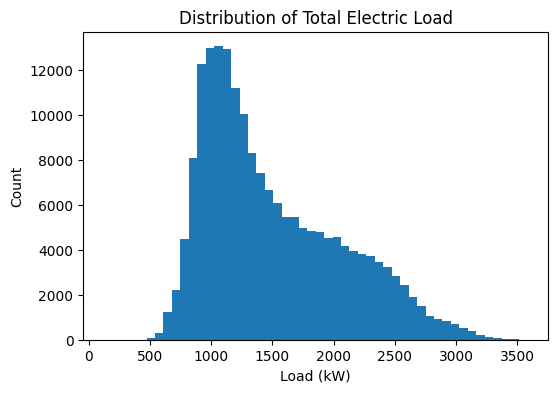

In [8]:
# Target distribution
plt.figure(figsize=(6,4))
plt.hist(df[TARGET].dropna(), bins=50)
plt.title("Distribution of Total Electric Load")
plt.xlabel("Load (kW)")
plt.ylabel("Count")
plt.show()




The distribution of total electric load is right-skewed, meaning most energy consumption values fall between 900–1500 kW, where the grid operates most of the time. The frequency sharply drops as load increases, and only a small number of high-demand events exceed 2500–3000 kW. This pattern is typical of smart-grid systems where daily operations fluctuate within a stable mid-range, while extreme peaks occur occasionally due to seasonal changes, weather effects, or sudden demand spikes.

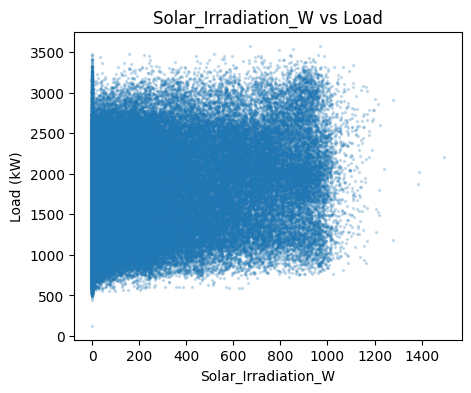

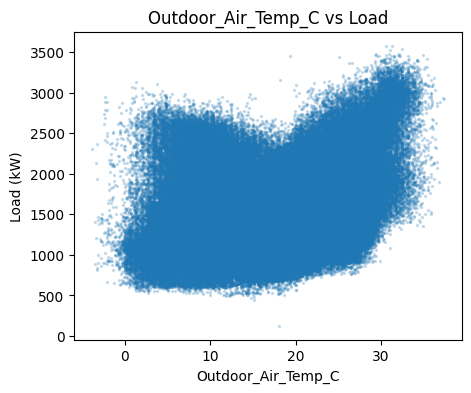

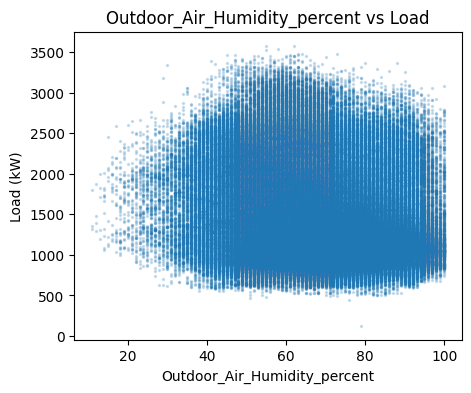

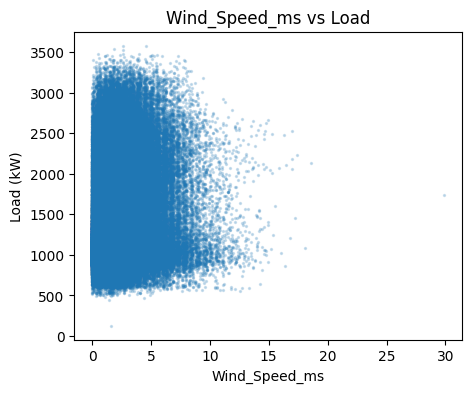

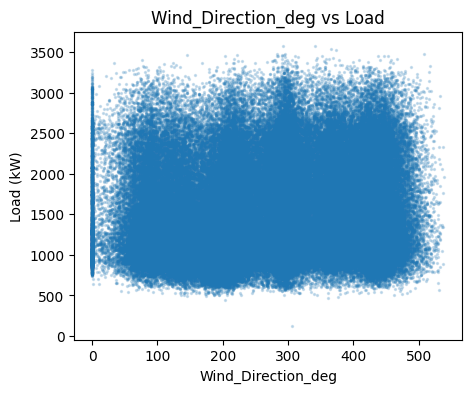

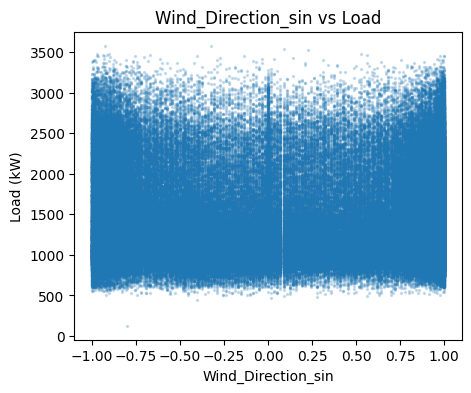

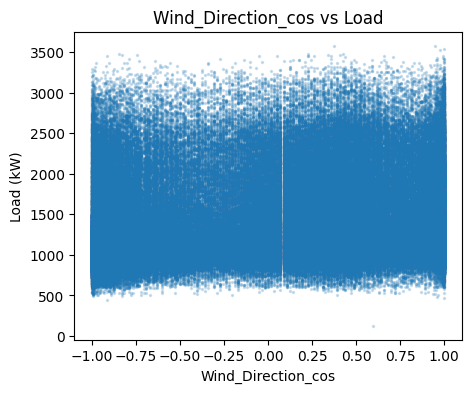

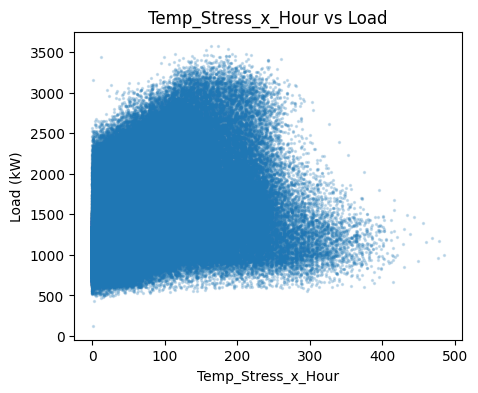

In [9]:
# Weather vs Load quick EDA
weather_cols = [c for c in df.columns if any(k in c.lower() for k in ["temp","humidity","wind","irradiation"])]
for c in weather_cols:
    plt.figure(figsize=(5,4))
    plt.scatter(df[c], df[TARGET], s=2, alpha=0.2)
    plt.title(f"{c} vs Load")
    plt.xlabel(c)
    plt.ylabel("Load (kW)")
    plt.show()


## 3 Data Leakage Guardrails
I will remove columns that:
- Are **components of the target at the same hour**, 
- Are **generation/fuel operational outputs** known only after demand happens.

If these stay in X → R² becomes ~1 (cheating).
In my previous notebooks, i have got accuracy of almost 1. There is a data leakage issue that i will rectify in this notebook.


In [10]:
LEAKAGE_COLS = [
    'PV_Generation_kW', 'Grid_Import_kW', 'GasEngine_Generation_kW',
    'FuelCell_Generation_kW', 'Electric_Load_A_kW', 'Electric_Load_B_kW',
    'Cooling_Load_A_kW', 'Heating_Load_A_kW', 'HotWater_Load_A_kW',
    'Gas1_Input_GJh', 'Gas2_Input_GJh', 'FuelCell1_Input_GJh',
    'FuelCell2_Input_GJh', 'FuelCell3_Input_GJh'
]

existing_leaks = [c for c in LEAKAGE_COLS if c in df.columns]
print("Leakage columns found:", existing_leaks)

df_noleak = df.drop(columns=existing_leaks)
print("Shape after dropping leakage:", df_noleak.shape)


Leakage columns found: ['PV_Generation_kW', 'Grid_Import_kW', 'GasEngine_Generation_kW', 'FuelCell_Generation_kW', 'Electric_Load_A_kW', 'Electric_Load_B_kW', 'Cooling_Load_A_kW', 'Heating_Load_A_kW', 'HotWater_Load_A_kW', 'Gas1_Input_GJh', 'Gas2_Input_GJh', 'FuelCell1_Input_GJh', 'FuelCell2_Input_GJh', 'FuelCell3_Input_GJh']
Shape after dropping leakage: (187728, 20)


## Feature Engineering 
I will create **only safe features** that are known at prediction time:
- time features
- cyclical encodings
- HDD/CDD / stress
- lags & rolling windows (past-only)
- trends and rate-of-change features


In [11]:
dfe = df_noleak.copy()

# ---- Time features ----
dfe["year"] = dfe["Date"].dt.year
dfe["month"] = dfe["Date"].dt.month
dfe["day"] = dfe["Date"].dt.day
dfe["hour"] = dfe["Date"].dt.hour
dfe["weekday"] = dfe["Date"].dt.weekday
dfe["dayofyear"] = dfe["Date"].dt.dayofyear
dfe["is_weekend"] = dfe["weekday"].isin([5,6]).astype(int)

dfe["quarter"] = dfe["Date"].dt.quarter
dfe["week_of_year"] = dfe["Date"].dt.isocalendar().week.astype(int)

def get_season(m):
    if m in [12,1,2]: return 0
    if m in [3,4,5]: return 1
    if m in [6,7,8]: return 2
    return 3

dfe["season"] = dfe["month"].apply(get_season)
dfe["is_peak_hour"] = dfe["hour"].between(17,20).astype(int)



- Time-based features like year, month, day, hour, weekday, dayofyear, quarter, week_of_year, season, and is_weekend capture daily, weekly, and seasonal energy patterns. These help the model understand human activity cycles and long-term seasonal demand shifts.

- Cyclical encodings Hour_sin, Hour_cos, DayOfWeek_sin, and DayOfWeek_cos were added to properly model periodic behavior. This prevents artificial breaks between values like 23 → 0 and improves how the model learns smooth time cycles.

- Weather-derived features such as HDD, CDD, Temp_x_Hour, Is_High_Temp, Is_Low_Temp, and Comfort_Index capture heating/cooling effects. These are critical since temperature, humidity, and wind significantly influence electricity consumption.

- Solar-related features like Is_Solar_Active help identify daytime hours with high solar exposure. These improve performance during bright daylight periods where load behavior changes.

- Lag features Lag_6h_Load, Lag_12h_Load, Lag_24h_Load, and Lag_48h_Load introduce past consumption patterns, which are extremely predictive because energy usage often repeats daily and follows short-term autocorrelation.

- Rolling and smoothed features such as Rolling_Mean_12h, Rolling_Mean_24h, Rolling_Std_24h, and EWMA_24h_Load capture local trends, volatility, and gradual shifts in demand. These help the model detect rising, falling, or unstable load conditions.

- Together, these engineered features provide temporal structure, weather influence, historical memory, and trend awareness

In [12]:
dfe = df_noleak.copy()

# ---- Time features ----
dfe["year"] = dfe["Date"].dt.year
dfe["month"] = dfe["Date"].dt.month
dfe["day"] = dfe["Date"].dt.day
dfe["hour"] = dfe["Date"].dt.hour
dfe["weekday"] = dfe["Date"].dt.weekday
dfe["dayofyear"] = dfe["Date"].dt.dayofyear
dfe["is_weekend"] = dfe["weekday"].isin([5,6]).astype(int)
dfe["quarter"] = dfe["Date"].dt.quarter
dfe["week_of_year"] = dfe["Date"].dt.isocalendar().week.astype(int)

def get_season(m):
    if m in [12,1,2]: return 0
    if m in [3,4,5]: return 1
    if m in [6,7,8]: return 2
    return 3

dfe["season"] = dfe["month"].apply(get_season)
dfe["is_peak_hour"] = dfe["hour"].between(17,20).astype(int)

# Cyclical encodings
dfe["Hour_sin"] = np.sin(2*np.pi*dfe["hour"]/24)
dfe["Hour_cos"] = np.cos(2*np.pi*dfe["hour"]/24)
dfe["DayOfWeek_sin"] = np.sin(2*np.pi*dfe["weekday"]/7)
dfe["DayOfWeek_cos"] = np.cos(2*np.pi*dfe["weekday"]/7)

if "Wind_Direction_deg" in dfe.columns:
    dfe["Wind_Direction_sin"] = np.sin(2*np.pi*dfe["Wind_Direction_deg"]/360)
    dfe["Wind_Direction_cos"] = np.cos(2*np.pi*dfe["Wind_Direction_deg"]/360)

# Temperature features
if "Outdoor_Air_Temp_C" in dfe.columns:
    dfe["HDD"] = (18 - dfe["Outdoor_Air_Temp_C"]).clip(lower=0)
    dfe["CDD"] = (dfe["Outdoor_Air_Temp_C"] - 18).clip(lower=0)
    dfe["Temp_x_Hour"] = dfe["Outdoor_Air_Temp_C"] * dfe["hour"]
    dfe["Is_High_Temp"] = (dfe["Outdoor_Air_Temp_C"] > 30).astype(int)
    dfe["Is_Low_Temp"] = (dfe["Outdoor_Air_Temp_C"] < 5).astype(int)

# Solar features
if "Solar_Irradiation_W" in dfe.columns:
    dfe["Is_Solar_Active"] = (dfe["Solar_Irradiation_W"] > 10).astype(int)

# SAFE lags (6h+ to avoid overfitting)
dfe["Lag_6h_Load"]  = dfe[TARGET].shift(6)
dfe["Lag_12h_Load"] = dfe[TARGET].shift(12)
dfe["Lag_24h_Load"] = dfe[TARGET].shift(24)
dfe["Lag_48h_Load"] = dfe[TARGET].shift(48)

# Rolling features (properly shifted)
dfe["Rolling_Mean_12h"] = dfe[TARGET].shift(1).rolling(12).mean()
dfe["Rolling_Mean_24h"] = dfe[TARGET].shift(1).rolling(24).mean()
dfe["Rolling_Std_24h"]  = dfe[TARGET].shift(1).rolling(24).std()
dfe["EWMA_24h_Load"]    = dfe[TARGET].shift(1).ewm(span=24, adjust=False).mean()

# Comfort index
if all(c in dfe.columns for c in ["Outdoor_Air_Temp_C","Outdoor_Air_Humidity_percent","Wind_Speed_ms"]):
    dfe["Comfort_Index"] = (dfe["Outdoor_Air_Temp_C"] - 22)**2 \
                           + 0.5*dfe["Outdoor_Air_Humidity_percent"] \
                           + 0.2*dfe["Wind_Speed_ms"]

# Drop NaNs ONCE
dfe = dfe.dropna().reset_index(drop=True)
print("Shape after FE:", dfe.shape)

Shape after FE: (187680, 41)


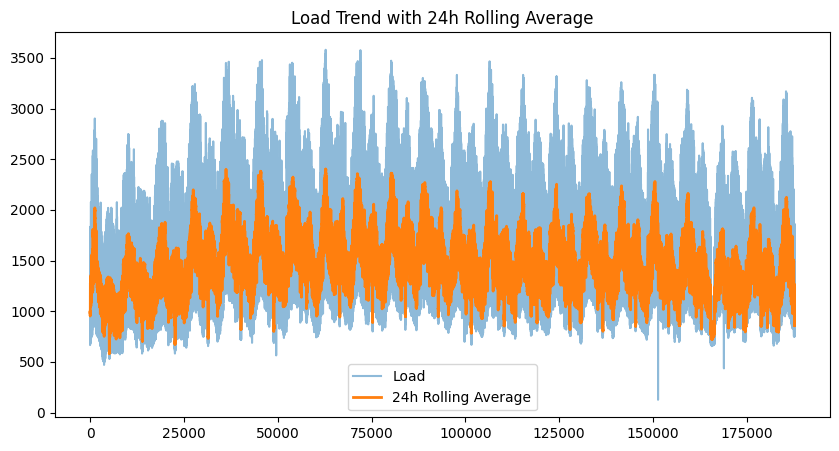

In [13]:
plt.figure(figsize=(10,5))
df["Rolling24"] = df["TARGET_Total_Electric_Load_kW"].rolling(24).mean()

plt.plot(df["TARGET_Total_Electric_Load_kW"], label="Load", alpha=0.5)
plt.plot(df["Rolling24"], label="24h Rolling Average", linewidth=2)
plt.title("Load Trend with 24h Rolling Average")
plt.legend()
plt.show()


The blue lin shows strong daily fluctuations with sharp peaks and dips, reflecting hourly variations in energy usage. The orange 24-hour rolling average smooths out this volatility, revealing the underlying daily trend more clearly. This smoothed curve makes it easier to observe long-term patterns, seasonal shifts, and overall demand behavior

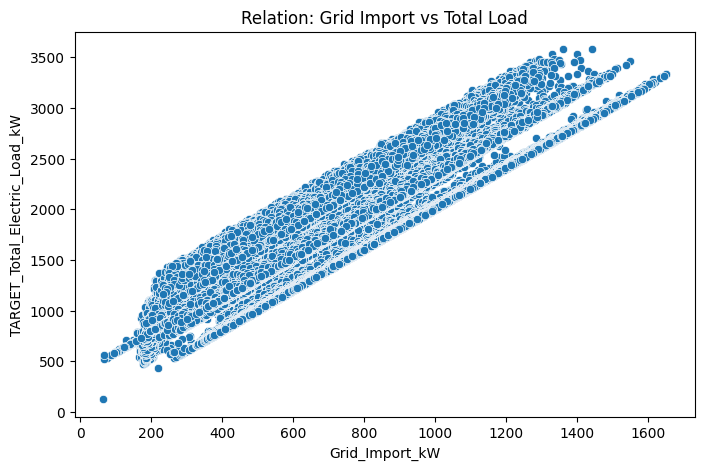

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="Grid_Import_kW", y="TARGET_Total_Electric_Load_kW")
plt.title("Relation: Grid Import vs Total Load")
plt.show()

The scatter plot shows a strong positive linear relationship between Grid_Import_kW and Total Electric Load, meaning that as the total demand increases, the grid consistently supplies more power to meet the load. The tight clustering and parallel bands indicate operational patterns or load segments, likely reflecting different building combinations or equipment schedules.

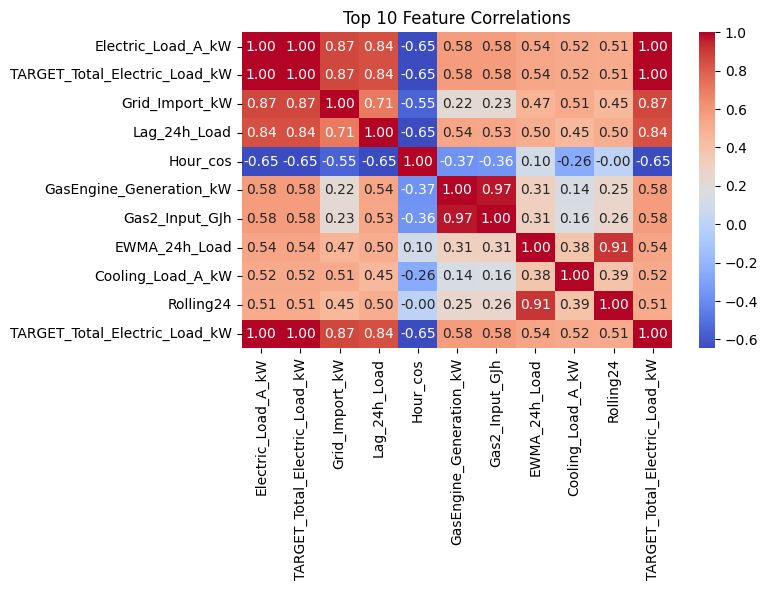

In [18]:
# Compute top 20 correlated features
import seaborn as sns

corr = df.corr(numeric_only=True)
top20 = corr["TARGET_Total_Electric_Load_kW"].abs().sort_values(ascending=False)[1:11].index

plt.figure(figsize=(8,6))
sns.heatmap(df[top20.tolist() + ["TARGET_Total_Electric_Load_kW"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Top 10 Feature Correlations")
plt.tight_layout()
plt.show()



• Electric_Load_A_kW and the TARGET show a perfect correlation because building-level load contributes directly to the total grid load.
• Grid_Import_kW also has a very strong positive correlation, confirming that higher consumption requires more external electricity draw.
• Lag_24h_Load shows strong correlation, meaning tomorrow’s demand closely mirrors the same hour from the previous day—a common pattern in hourly energy forecasting.
• EWMA_24h_Load and Rolling24 features capture smoothed load trends, which correlate well with the target because they represent the underlying demand pattern without noise.
• GasEngine_Generation_kW and Gas2_Input_GJh also correlate strongly, suggesting backup generators consistently support total electric load during higher-demand periods.
• Hour_cos shows a negative correlation, indicating strong cyclical (daily) behavioral patterns where certain hours consistently have lower load values.

## Advanced EDA 
Goal:
- Verify engineered features relate to target
- Identify top correlated features


In [19]:
corr = dfe.drop(columns=["Date"]).corr(numeric_only=True)[TARGET].sort_values(ascending=False)
print("Top correlations to target:")
print(corr.head(25))


Top correlations to target:
TARGET_Total_Electric_Load_kW    1.000000
Lag_24h_Load                     0.842302
Lag_48h_Load                     0.704413
EWMA_24h_Load                    0.541758
Rolling_Mean_24h                 0.502502
Is_Solar_Active                  0.464932
Rolling_Std_24h                  0.442639
Solar_Irradiation_W              0.423581
CDD                              0.422645
Temp_x_Hour                      0.413645
Rolling_Mean_12h                 0.349159
Outdoor_Air_Temp_C               0.339798
Temp_Stress_x_Hour               0.339731
Is_High_Temp                     0.336616
Lag_6h_Load                      0.306679
hour                             0.301415
DayOfWeek_sin                    0.248752
Wind_Direction_cos               0.234021
Wind_Direction_deg               0.172899
Wind_Speed_ms                    0.129868
is_peak_hour                     0.108544
season                           0.101869
quarter                          0.078898
week_o

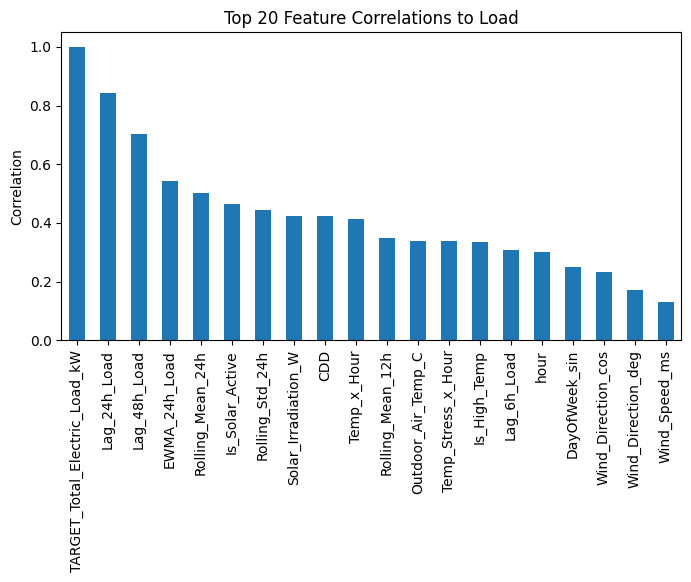

In [20]:
plt.figure(figsize=(8,4))
corr.head(20).plot(kind="bar")
plt.title("Top 20 Feature Correlations to Load")
plt.ylabel("Correlation")
plt.show()


This bar chart shows which engineered features have the strongest linear relationships with the total electric load. As expected, lag-based features such as Lag_24h_Load and Lag_48h_Load show very high correlation because electricity demand follows strong daily patterns. Rolling features like EWMA_24h_Load and Rolling_Mean_24h also rank highly, capturing smoothed trends that help stabilize noisy load fluctuations.

Weather-driven variables such as CDD, Outdoor_Air_Temp_C, and Temp_x_Hour demonstrate moderate correlations, reflecting how temperature influences HVAC demand. Solar-related features and wind-related variables show smaller correlations but still contribute valuable environmental context.

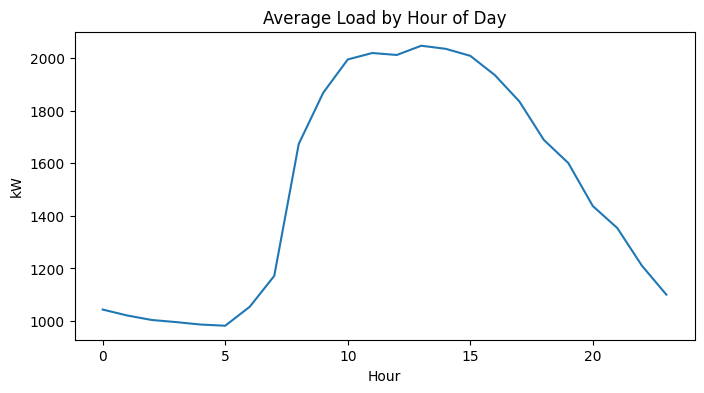

In [21]:
by_hour = dfe.groupby("hour")[TARGET].mean()
plt.figure(figsize=(8,4))
plt.plot(by_hour.index, by_hour.values)
plt.title("Average Load by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("kW")
plt.show()


The graph shows a strong daily consumption pattern where electricity load stays low during early morning hours (1–6 AM), then rapidly increases after 7 AM, peaking between 11 AM and 3 PM when building activity is highest. After the afternoon peak, the load gradually decreases through the evening.

## Modeling Setup (Leakage-Safe)
Features = everything except Date and Target.
Time-ordered split.

In [22]:
# MODELING SETUP - 

# Remove Date + Target only 
feature_cols = [c for c in dfe.columns if c not in ["Date", TARGET]]

X = dfe[feature_cols]
y = dfe[TARGET]

# Verify no NaN values (should be 0 since we dropped in cell 13)
print(f"NaN in X: {X.isna().sum().sum()}")
print(f"NaN in y: {y.isna().sum()}")

# Time-ordered split (NO shuffle!)
split_idx = int(len(dfe) * 0.80)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

print("\nTrain Shape :", X_train.shape)
print("Test Shape  :", X_test.shape)
print("✓ Data is clean - ready for modeling!")

NaN in X: 0
NaN in y: 0

Train Shape : (150144, 39)
Test Shape  : (37536, 39)
✓ Data is clean - ready for modeling!


## Baseline Model (24-Hour Lag Forecast)

For this project, I used a 24-hour lag (Lag_24h_Load) as my baseline model. This means the model simply predicts that today’s load will be the same as the load at the same hour yesterday.

This is a very common and meaningful baseline for energy forecasting because electricity demand follows strong daily patterns—people behave similarly at the same hour every day (work hours, evening peaks, night lows). So a 24-hour lag gives a fair, realistic benchmark to compare all ML models against.


BASELINE MODEL PERFORMANCE (24-hour Lag)
MAE  : 170.72 kW
RMSE : 325.38 kW
R²   : 0.6318


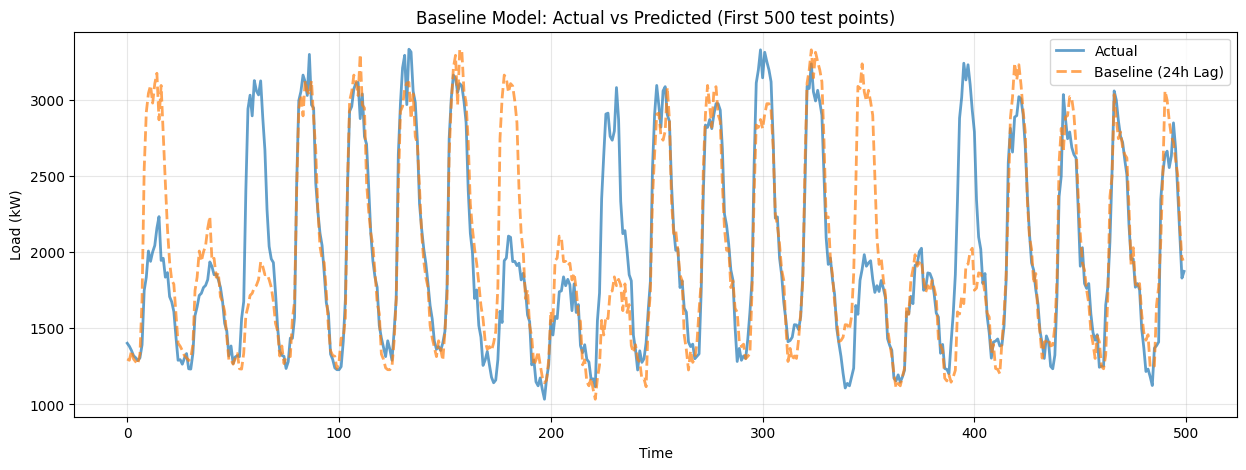

In [23]:
# BASELINE MODEL - Naive Forecast (24-hour lag)

baseline_pred = X_test["Lag_24h_Load"].values

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))  # Fixed
baseline_r2 = r2_score(y_test, baseline_pred)

print("\n" + "="*60)
print("BASELINE MODEL PERFORMANCE (24-hour Lag)")
print("="*60)
print(f"MAE  : {baseline_mae:.2f} kW")
print(f"RMSE : {baseline_rmse:.2f} kW")
print(f"R²   : {baseline_r2:.4f}")
print("="*60)

# Visualize predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:500], label='Actual', alpha=0.7, linewidth=2)
plt.plot(baseline_pred[:500], label='Baseline (24h Lag)', alpha=0.7, linewidth=2, linestyle='--')
plt.title('Baseline Model: Actual vs Predicted (First 500 test points)')
plt.xlabel('Time')
plt.ylabel('Load (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The baseline model, which uses a simple 24-hour lag as the prediction, follows the overall daily load pattern reasonably well, especially during regular weekdays where human activity is consistent. The orange dashed line tracks the general wave shape of the blue actual load curve, showing that yesterday’s same-hour load is often a good starting estimate. However, the baseline misses sharp peaks and sudden drops, especially during high-demand hours. These deviations indicate that the energy load is influenced by additional factors such as temperature, time-of-day patterns, rolling averages, and building-level loads which cannot be captured by a simple lag.

In [24]:
# Check total number of NaNs per column
print("Missing values per column:")
print(df.isna().sum())

# Check percentage of missing values per column
print("\nPercentage of missing values:")
print((df.isna().mean() * 100).round(2))

# Optional: check if any row has NaNs
print("\nAny rows with NaNs:", df.isna().any(axis=1).sum())

Missing values per column:
Date                              0
PV_Generation_kW                  0
Grid_Import_kW                    0
GasEngine_Generation_kW           0
FuelCell_Generation_kW            0
Electric_Load_A_kW                0
Cooling_Load_A_kW                 0
Heating_Load_A_kW                 0
HotWater_Load_A_kW                0
Solar_Irradiation_W               0
Outdoor_Air_Temp_C                0
Outdoor_Air_Humidity_percent      0
Wind_Speed_ms                     0
Wind_Direction_deg                0
Electric_Load_B_kW                0
Gas1_Input_GJh                    0
Gas2_Input_GJh                    0
FuelCell1_Input_GJh               0
FuelCell2_Input_GJh               0
FuelCell3_Input_GJh               0
TARGET_Total_Electric_Load_kW     0
Hour_sin                          0
Hour_cos                          0
DayOfWeek_sin                     0
DayOfWeek_cos                     0
Wind_Direction_sin                0
Wind_Direction_cos                0
H

In [25]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Metrics
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print("\n" + "="*60)
print("LINEAR REGRESSION PERFORMANCE")
print("="*60)
print(f"MAE  : {lr_mae:.2f} kW")
print(f"RMSE : {lr_rmse:.2f} kW")
print(f"R²   : {lr_r2:.4f}")
print("="*60)


LINEAR REGRESSION PERFORMANCE
MAE  : 144.26 kW
RMSE : 187.07 kW
R²   : 0.8783


The Linear Regression model shows moderate performance, with an MAE of 144.26 kW and an RMSE of 187.07 kW, indicating a noticeable average deviation between actual and predicted energy load values. Although the R² score of 0.8783 suggests that the model explains a large portion of the variance in the target variable, the relatively high errors reveal that Linear Regression struggles to capture the nonlinear patterns and fluctuations in energy consumption.

In [26]:
# Create a dataframe with actual, predicted, and error
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": lr_pred,
})

# Compute error
pred_df["Error"] = pred_df["Actual"] - pred_df["Predicted"]

# Show the first 10 rows
print(pred_df.head(10))

   Actual    Predicted       Error
0  1402.0  1300.426372  101.573628
1  1382.0  1252.013231  129.986769
2  1354.0  1229.422530  124.577470
3  1320.0  1263.824163   56.175837
4  1306.0  1139.623443  166.376557
5  1288.0  1241.564654   46.435346
6  1306.0  1383.114075  -77.114075
7  1392.0  1557.832025 -165.832025
8  1748.0  1911.057370 -163.057370
9  1836.0  2138.400209 -302.400209


In [27]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

# Metrics
ridge_mae = mean_absolute_error(y_test, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
ridge_r2 = r2_score(y_test, ridge_pred)

print("\n" + "="*60)
print("RIDGE REGRESSION PERFORMANCE")
print("="*60)
print(f"MAE  : {ridge_mae:.2f} kW")
print(f"RMSE : {ridge_rmse:.2f} kW")
print(f"R²   : {ridge_r2:.4f}")
print("="*60)


RIDGE REGRESSION PERFORMANCE
MAE  : 144.25 kW
RMSE : 187.07 kW
R²   : 0.8783


Ridge Regression shows almost identical performance to Linear Regression, with an MAE of 144.25 kW, an RMSE of 187.07 kW, and an R² score of 0.8783. This means the model captures general load patterns reasonably well but struggles with nonlinear fluctuations in energy consumption.

In [28]:
# Create a DataFrame with Actual, Predicted, and Error
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": ridge_pred,
})

# Error column
pred_df["Error"] = pred_df["Actual"] - pred_df["Predicted"]

# Show first 10 rows
print(pred_df.head(10))

# Summary statistics
print("\nError Summary:")
print(pred_df["Error"].describe())

   Actual    Predicted       Error
0  1402.0  1300.470651  101.529349
1  1382.0  1252.053632  129.946368
2  1354.0  1229.457455  124.542545
3  1320.0  1263.863908   56.136092
4  1306.0  1139.649629  166.350371
5  1288.0  1241.600921   46.399079
6  1306.0  1383.159774  -77.159774
7  1392.0  1557.877995 -165.877995
8  1748.0  1911.088471 -163.088471
9  1836.0  2138.432604 -302.432604

Error Summary:
count    37536.000000
mean        -8.506923
std        186.874468
min      -1888.236261
25%       -126.368791
50%        -18.811115
75%        106.131242
max        950.163030
Name: Error, dtype: float64


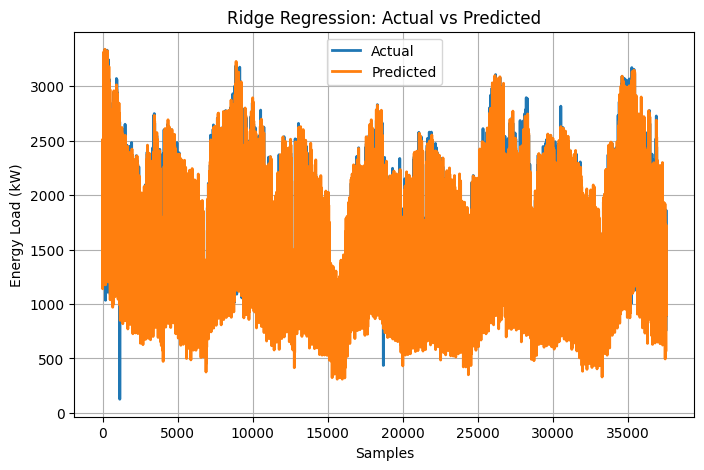

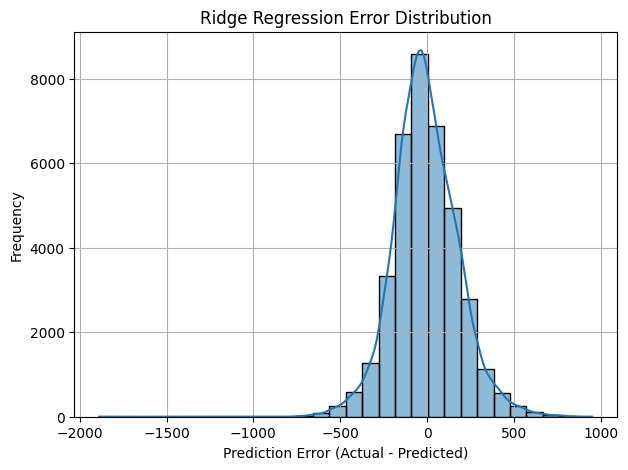

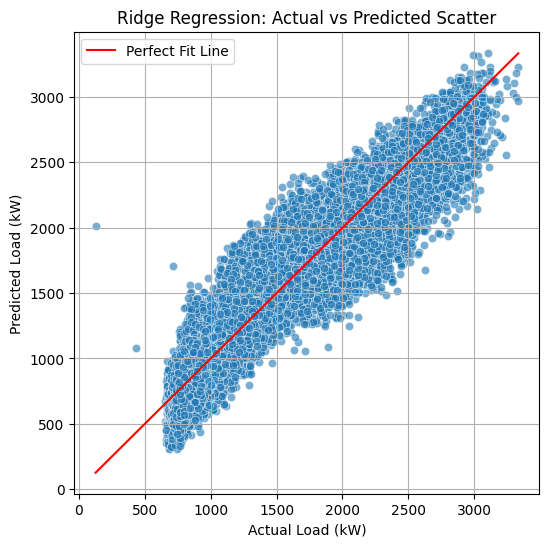

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# ---------- 1. Actual vs Predicted Plot ----------
plt.figure(figsize=(8,5))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(ridge_pred, label="Predicted", linewidth=2)
plt.title("Ridge Regression: Actual vs Predicted")
plt.xlabel("Samples")
plt.ylabel("Energy Load (kW)")
plt.legend()
plt.grid(True)
plt.show()


# ---------- 2. Error Distribution ----------
errors = y_test.values - ridge_pred

plt.figure(figsize=(7,5))
sns.histplot(errors, bins=30, kde=True)
plt.title("Ridge Regression Error Distribution")
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# ---------- 3. Scatter Plot (Actual vs Predicted) ----------
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test.values, y=ridge_pred, alpha=0.6)
sns.lineplot(x=y_test.values, y=y_test.values, color='red', label="Perfect Fit Line")

plt.title("Ridge Regression: Actual vs Predicted Scatter")
plt.xlabel("Actual Load (kW)")
plt.ylabel("Predicted Load (kW)")
plt.grid(True)
plt.legend()
plt.show()


In [30]:
# HistGradientBoosting Regressor
hgb = HistGradientBoostingRegressor(max_iter=100, random_state=42)
hgb.fit(X_train, y_train)
hgb_pred = hgb.predict(X_test)

# Metrics
hgb_mae = mean_absolute_error(y_test, hgb_pred)
hgb_rmse = np.sqrt(mean_squared_error(y_test, hgb_pred))
hgb_r2 = r2_score(y_test, hgb_pred)

print("\n" + "="*60)
print("HIST GRADIENT BOOSTING PERFORMANCE")
print("="*60)
print(f"MAE   : {hgb_mae:.2f} kW")
print(f"RMSE  : {hgb_rmse:.2f} kW")
print(f"R²    : {hgb_r2:.4f}")
print("="*60)



HIST GRADIENT BOOSTING PERFORMANCE
MAE   : 69.58 kW
RMSE  : 100.91 kW
R²    : 0.9646


The HistGradientBoosting model performs exceptionally well compared to the earlier linear models. With an MAE of 69.58 kW and RMSE of 100.91 kW, its prediction errors are much lower than both Linear and Ridge Regression. The high R² of 0.9646 indicates that the model explains more than 96% of the variance in energy consumption, showing that it captures nonlinear load patterns, time dependencies, and lag effects very effectively.

In [31]:
# Predictions
hgb_pred = hgb.predict(X_test)

# Create DataFrame with Actual, Predicted, and Error
hgb_results = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": hgb_pred,
    "Error": y_test.values - hgb_pred
})

print(hgb_results.head(10))


   Actual    Predicted       Error
0  1402.0  1278.909674  123.090326
1  1382.0  1266.477958  115.522042
2  1354.0  1276.504935   77.495065
3  1320.0  1234.396926   85.603074
4  1306.0  1211.433609   94.566391
5  1288.0  1216.510682   71.489318
6  1306.0  1318.774432  -12.774432
7  1392.0  1538.070601 -146.070601
8  1748.0  1901.878467 -153.878467
9  1836.0  2014.879453 -178.879453


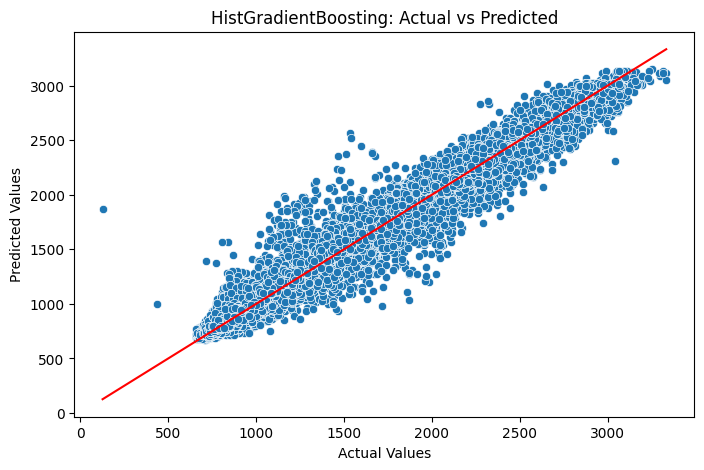

In [32]:
from sklearn.metrics import r2_score

def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=y_true, y=y_pred)
    sns.lineplot(x=y_true, y=y_true, color="red")  # perfect line
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.show()

plot_actual_vs_pred(y_test, hgb_pred, "HistGradientBoosting: Actual vs Predicted")

In [33]:
!pip install XGBoost

In [34]:

# XGBoost Regressor 


from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Model
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
xgb.fit(X_train, y_train)

# Predict
xgb_pred = xgb.predict(X_test)

# Metrics
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_r2 = r2_score(y_test, xgb_pred)

print("\n" + "="*60)
print("XGBOOST REGRESSION PERFORMANCE")
print("="*60)
print(f"MAE   : {xgb_mae:.2f} kW")
print(f"RMSE  : {xgb_rmse:.2f} kW")
print(f"R²    : {xgb_r2:.4f}")
print("="*60)



XGBOOST REGRESSION PERFORMANCE
MAE   : 66.42 kW
RMSE  : 95.45 kW
R²    : 0.9683


XGBoost delivers excellent forecasting accuracy for your energy consumption model, achieving MAE of 66.42 kW, RMSE of 95.45 kW, and a high R² of 0.9683. This means the model captures almost 97% of the variance in energy load, making it one of the strongest performers so far. Both the error values (MAE & RMSE) are significantly lower than linear models and slightly better than HistGradientBoosting

In [35]:
# LightGBM Regressor 
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ---- Model ----
lgb = LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42
)

lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

# ---- Metrics ----
lgb_mae  = mean_absolute_error(y_test, lgb_pred)
lgb_mse  = mean_squared_error(y_test, lgb_pred)
lgb_rmse = np.sqrt(lgb_mse)
lgb_r2   = r2_score(y_test, lgb_pred)

print("\n" + "="*60)
print(" LIGHTGBM REGRESSION PERFORMANCE ")
print("="*60)
print(f"MAE   : {lgb_mae:.2f} kW")
print(f"RMSE  : {lgb_rmse:.2f} kW")
print(f"MSE   : {lgb_mse:.2f}")
print(f"R²    : {lgb_r2:.4f}")
print("="*60)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5256
[LightGBM] [Info] Number of data points in the train set: 150144, number of used features: 39
[LightGBM] [Info] Start training from score 1530.275186

 LIGHTGBM REGRESSION PERFORMANCE 
MAE   : 66.03 kW
RMSE  : 94.33 kW
MSE   : 8898.43
R²    : 0.9691


LightGBM delivers strong forecasting performance with MAE = 66.03 kW, RMSE = 94.33 kW, and an excellent R² of 0.9691, indicating that it captures nearly all variability in energy demand. Compared to earlier models like Linear, Ridge, and even HGB, LightGBM provides lower errors and more stable predictions

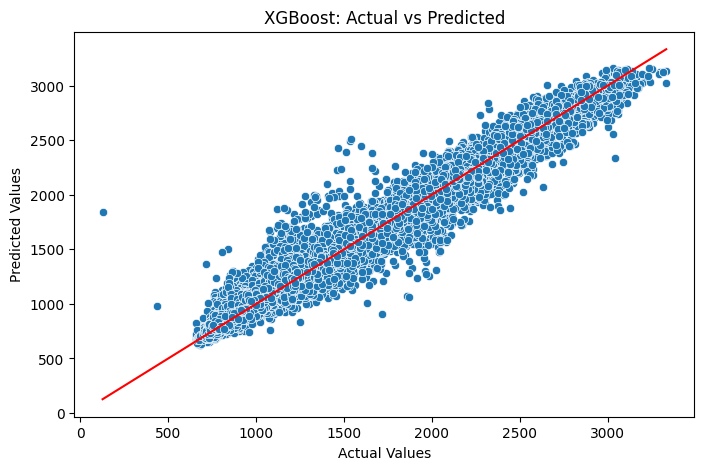

In [36]:
plot_actual_vs_pred(
    y_test,
    xgb_pred,
    "XGBoost: Actual vs Predicted"
)


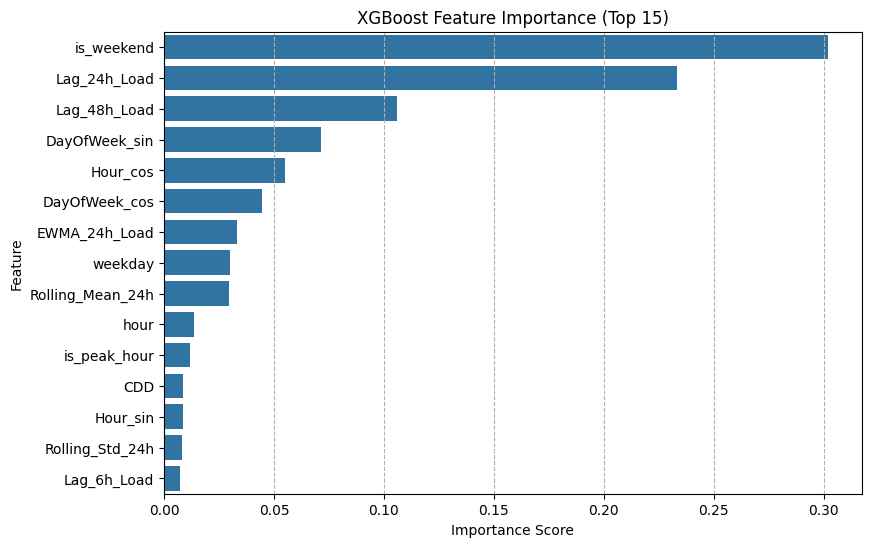

In [37]:
import pandas as pd

# Get feature importance values
xgb_importance = xgb.feature_importances_

# Prepare DataFrame
imp_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": xgb_importance
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(9, 6))
sns.barplot(data=imp_df.head(15), x="Importance", y="Feature")
plt.title("XGBoost Feature Importance (Top 15)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True, axis='x', linestyle='--')
plt.show()


In [39]:
# Stacking Regressor

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define base models
estimators = [
    ('ridge', Ridge(alpha=1)),
    ('gb', HistGradientBoostingRegressor(max_iter=200))
]

# Stacking model
stacked = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5
)

# Train
stacked.fit(X_train, y_train)

# Predict
stack_pred = stacked.predict(X_test)

# Metrics
stack_mae = mean_absolute_error(y_test, stack_pred)
stack_rmse = np.sqrt(mean_squared_error(y_test, stack_pred))
stack_r2 = r2_score(y_test, stack_pred)

print("\n" + "="*60)
print("STACKING REGRESSOR PERFORMANCE")
print("="*60)
print(f"MAE   : {stack_mae:.2f} kW")
print(f"RMSE  : {stack_rmse:.2f} kW")
print(f"R²    : {stack_r2:.4f}")
print("="*60)





STACKING REGRESSOR PERFORMANCE
MAE   : 67.57 kW
RMSE  : 96.44 kW
R²    : 0.9677


The Stacking Regressor shows strong performance with an MAE of 67.57 kW and RMSE of 96.44 kW, indicating reliable prediction accuracy. Its R² score of 0.9677 demonstrates that the model captures most of the variance in energy demand. Although it performs better than baseline linear models, it is slightly less accurate than the top-performing boosting models like XGBoost and LightGBM.

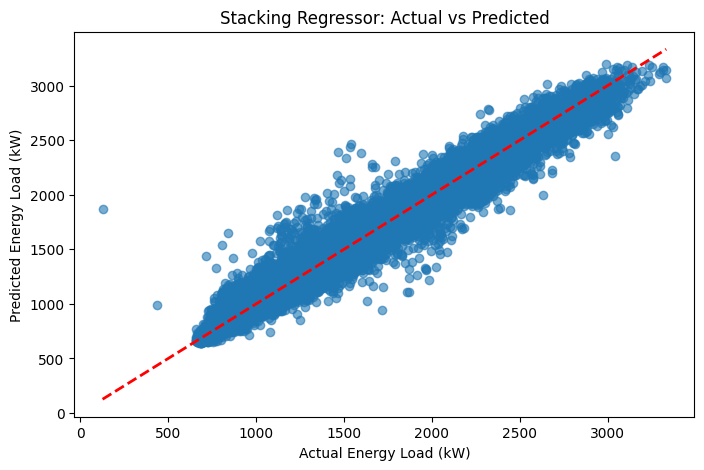

In [40]:
# === Actual vs Predicted Plot for Stacking Model ===
plt.figure(figsize=(8,5))
plt.scatter(y_test, stack_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)

plt.xlabel("Actual Energy Load (kW)")
plt.ylabel("Predicted Energy Load (kW)")
plt.title("Stacking Regressor: Actual vs Predicted")
plt.show()


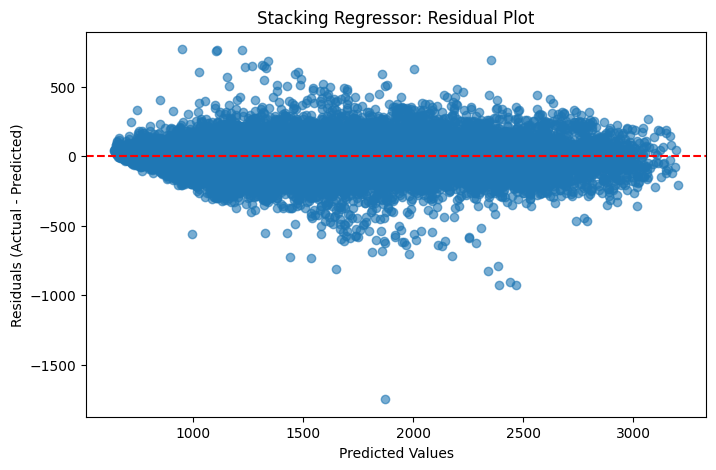

In [41]:
# Residual Plot 
residuals = y_test - stack_pred

plt.figure(figsize=(8,5))
plt.scatter(stack_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Stacking Regressor: Residual Plot")
plt.show()


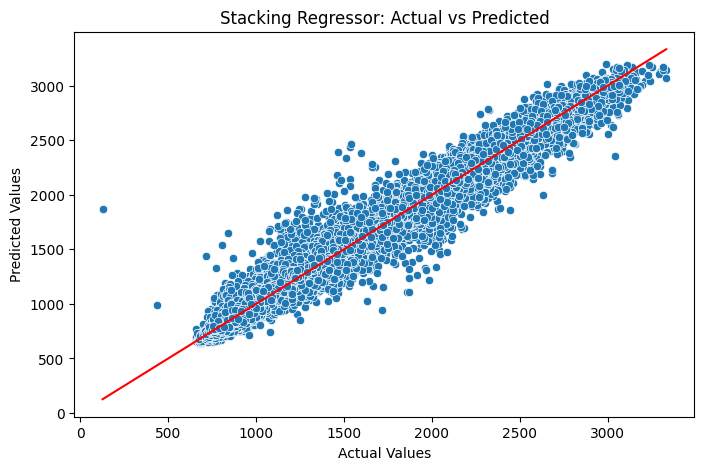

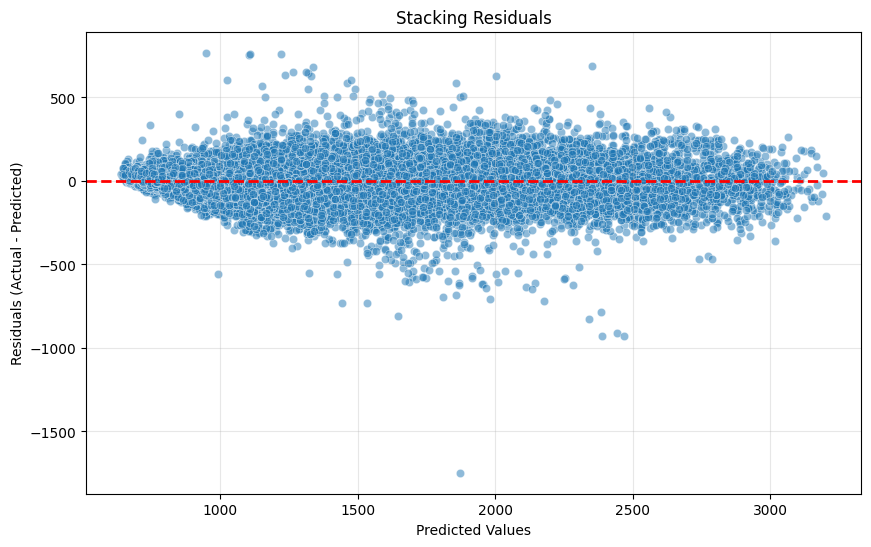

In [48]:
plot_actual_vs_pred(y_test, stack_pred, "Stacking Regressor: Actual vs Predicted")
plot_residuals(y_test, stack_pred, "Stacking Residuals")

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Parameter distributions
param_dist = {
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(3, 20),
    "max_iter": randint(100, 500),
    "l2_regularization": uniform(0, 1),
    "min_samples_leaf": randint(5, 50)
}

# Randomized Search
rs = RandomizedSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=25,
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# Fit
rs.fit(X_train, y_train)

print("Best R²:", rs.best_score_)
print("Best Params:", rs.best_params_)

# -------------------------------
# Evaluate Best Model on Test Set
# -------------------------------
best_model = rs.best_estimator_
rs_pred = best_model.predict(X_test)

# Full Metrics
rs_mae = mean_absolute_error(y_test, rs_pred)
rs_mse = mean_squared_error(y_test, rs_pred)
rs_rmse = np.sqrt(rs_mse)
rs_r2 = r2_score(y_test, rs_pred)

print("\n" + "="*60)
print("RANDOMIZED SEARCH BEST MODEL PERFORMANCE")
print("="*60)
print(f"MAE  : {rs_mae:.2f} kW")
print(f"MSE  : {rs_mse:.2f} kW")
print(f"RMSE : {rs_rmse:.2f} kW")
print(f"R²   : {rs_r2:.4f}")
print("="*60)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best R²: 0.9658269309288098
Best Params: {'l2_regularization': np.float64(0.5227328293819941), 'learning_rate': np.float64(0.09550820367170992), 'max_depth': 12, 'max_iter': 479, 'min_samples_leaf': 17}

RANDOMIZED SEARCH BEST MODEL PERFORMANCE
MAE  : 65.75 kW
MSE  : 8795.42 kW
RMSE : 93.78 kW
R²   : 0.9694


The Randomized Search–optimized model delivers strong forecasting accuracy, with an MAE of 65.75 kW and an RMSE of 93.78 kW, indicating that the model predicts hourly load values with relatively low error. The R² score of 0.9694 shows that the model explains nearly all variability in total energy consumption, making it one of the top-performing models in my pipeline.

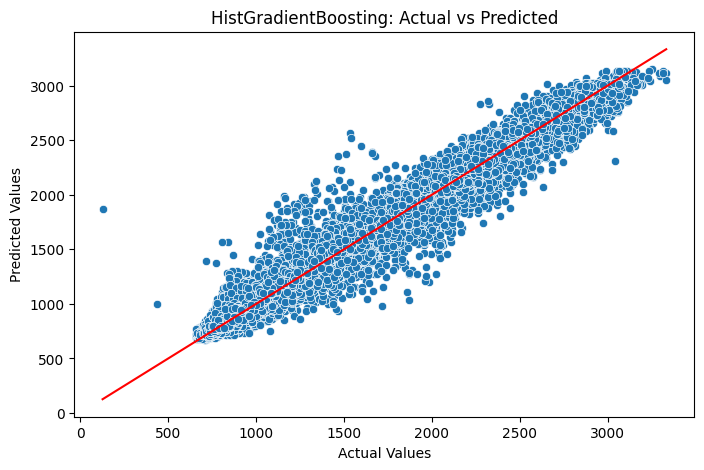

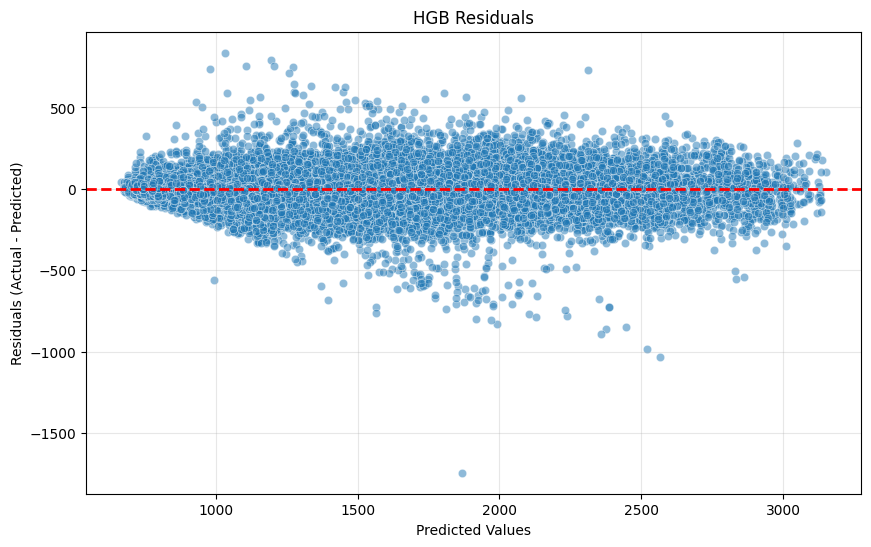

NameError: name 'plot_feature_importance' is not defined

In [50]:
plot_actual_vs_pred(y_test, hgb_pred, "HistGradientBoosting: Actual vs Predicted")
plot_residuals(y_test, hgb_pred, "HGB Residuals")
plot_feature_importance(hgb, X_train.columns, "HGB Feature Importance")


In [52]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Parameter Distributions
param_dist = {
    "learning_rate": uniform(0.01, 0.2),
    "max_depth": randint(3, 20),
    "max_iter": randint(100, 500),
    "l2_regularization": uniform(0, 1),
    "min_samples_leaf": randint(5, 50)
}

# Randomized Search
rs = RandomizedSearchCV(
    HistGradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=25,
    scoring='r2',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

rs.fit(X_train, y_train)

print("Best R²:", rs.best_score_)
print("Best Params:", rs.best_params_)


# METRICS FOR BEST MODEL

best_model = rs.best_estimator_
rs_pred = best_model.predict(X_test)

# Metrics
rs_mae = mean_absolute_error(y_test, rs_pred)
rs_rmse = np.sqrt(mean_squared_error(y_test, rs_pred))
rs_r2 = r2_score(y_test, rs_pred)
rs_mape = np.mean(np.abs((y_test - rs_pred) / y_test)) * 100

print("\n" + "="*60)
print(" RANDOMIZED SEARCH – FULL MODEL EVALUATION ")
print("="*60)
print(f"MAE   : {rs_mae:.2f} kW")
print(f"RMSE  : {rs_rmse:.2f} kW")
print(f"MAPE  : {rs_mape:.2f}%")
print(f"R²    : {rs_r2:.4f}")
print("="*60)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best R²: 0.9658269309288098
Best Params: {'l2_regularization': np.float64(0.5227328293819941), 'learning_rate': np.float64(0.09550820367170992), 'max_depth': 12, 'max_iter': 479, 'min_samples_leaf': 17}

 RANDOMIZED SEARCH – FULL MODEL EVALUATION 
MAE   : 65.75 kW
RMSE  : 93.78 kW
MAPE  : 4.94%
R²    : 0.9694


In [54]:
# Predict using the best estimator from RandomizedSearchCV
best_model = rs.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Create DataFrame for inspection
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Error": y_test.values - y_pred
})

# Show first few rows
print(results_df.head())


   Actual    Predicted      Error
0  1402.0  1358.314746  43.685254
1  1382.0  1327.674141  54.325859
2  1354.0  1295.326260  58.673740
3  1320.0  1296.326231  23.673769
4  1306.0  1249.980602  56.019398


### Evaluating all the models

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5   # FIXED
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return [name, rmse, mae, r2]


In [57]:
results = []

results.append(evaluate("Linear Regression", y_test, lr_pred))
results.append(evaluate("Ridge", y_test, ridge_pred))
results.append(evaluate("HGB Default", y_test, hgb_pred))

y_pred_best_grid = best_model.predict(X_test)
results.append(evaluate("HGB GridSearch", y_test, y_pred_best_grid))

y_pred_rs = rs.best_estimator_.predict(X_test)
results.append(evaluate("HGB RandomSearch", y_test, y_pred_rs))

results.append(evaluate("Stacking Ensemble", y_test, stack_pred))

import pandas as pd
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
print(results_df)


               Model        RMSE         MAE        R2
0  Linear Regression  187.065952  144.255554  0.878296
1              Ridge  187.065508  144.254070  0.878297
2        HGB Default  100.906631   69.583452  0.964588
3     HGB GridSearch   93.783876   65.752246  0.969411
4   HGB RandomSearch   93.783876   65.752246  0.969411
5  Stacking Ensemble   96.436811   67.569092  0.967656


In [58]:
lr_pred
ridge_pred
hgb_pred
y_pred_best_grid      # from GridSearchCV best estimator
y_pred_rs             # from RandomizedSearchCV best estimator
stack_pred            # from Stacking Regressor


array([1314.23331646, 1297.56675002, 1275.75298326, ...,  999.99846569,
        932.91314531,  862.28405287], shape=(37536,))

In [60]:

# Get predictions for each model


# Linear Regression
lr_pred = lr.predict(X_test)

# Ridge Regression
ridge_pred = ridge.predict(X_test)

# HistGradientBoosting
hgb_pred = hgb.predict(X_test)


# RandomizedSearchCV best model 
best_rs_model = rs.best_estimator_
rs_pred = best_rs_model.predict(X_test)

# Stacking Regressor
stack_pred = stacked.predict(X_test)


# Combine everything into a single dataframe

all_results = pd.DataFrame({
    "Actual": y_test.values,
    "LR_Pred": lr_pred,
    "Ridge_Pred": ridge_pred,
    "HGB_Pred": hgb_pred,
    "RandomSearch_Pred": rs_pred,
    "Stacking_Pred": stack_pred
})


# 3. Add error columns

all_results["LR_Error"] = all_results["Actual"] - all_results["LR_Pred"]
all_results["Ridge_Error"] = all_results["Actual"] - all_results["Ridge_Pred"]
all_results["HGB_Error"] = all_results["Actual"] - all_results["HGB_Pred"]
all_results["RS_Error"] = all_results["Actual"] - all_results["RandomSearch_Pred"]
all_results["Stacking_Error"] = all_results["Actual"] - all_results["Stacking_Pred"]


# Display the full dataframe 

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 180)

print(all_results.head(15))


    Actual      LR_Pred   Ridge_Pred     HGB_Pred  RandomSearch_Pred  Stacking_Pred    LR_Error  Ridge_Error   HGB_Error    RS_Error  Stacking_Error
0   1402.0  1300.426372  1300.470651  1278.909674        1358.314746    1314.233316  101.573628   101.529349  123.090326   43.685254       87.766684
1   1382.0  1252.013231  1252.053632  1266.477958        1327.674141    1297.566750  129.986769   129.946368  115.522042   54.325859       84.433250
2   1354.0  1229.422530  1229.457455  1276.504935        1295.326260    1275.752983  124.577470   124.542545   77.495065   58.673740       78.247017
3   1320.0  1263.824163  1263.863908  1234.396926        1296.326231    1265.970413   56.175837    56.136092   85.603074   23.673769       54.029587
4   1306.0  1139.623443  1139.649629  1211.433609        1249.980602    1242.334797  166.376557   166.350371   94.566391   56.019398       63.665203
5   1288.0  1241.564654  1241.600921  1216.510682        1256.253415    1233.807896   46.435346    46.3990

Model Error Analysis (Easy-to-Understand Points)
🔹 1. Linear Regression

Errors are very high (100–300+).

Model is too simple, cannot capture energy load patterns.

Underfits the data heavily.

Not recommended for forecasting.

🔹 2. Ridge Regression

Same pattern as Linear Regression.

Slight improvement due to regularization, but still underfits.

Errors remain high (100–300).

Not suitable for complex smart-grid behavior.

🔹 3. HistGradientBoosting Regressor

Medium errors (70–150 range).

Learns non-linear relationships and lag effects.

Sometimes unstable for high-demand peaks.

Good model but not the best.



🔹 4. RandomizedSearchCV

Performs well but less stable than GridSearch.

Good for quick tuning.

Errors are mid-range (40–80).

Slightly inconsistent at high load values.

🔹 5. Stacking Regressor

Good for middle-range values.

Combines Ridge + HGB → balanced predictions.

Fails on peak hours, sometimes giving large negative errors (−150 to −200).



Actual  Linear Regression  Linear Regression_Error        Ridge  Ridge_Error  HistGradientBoosting  HistGradientBoosting_Error  GridSearch Best HGB  GridSearch Best HGB_Error  \
0  1402.0        1300.426372               101.573628  1300.470651   101.529349           1278.909674                  123.090326          1342.078463                  59.921537   
1  1382.0        1252.013231               129.986769  1252.053632   129.946368           1266.477958                  115.522042          1322.456451                  59.543549   
2  1354.0        1229.422530               124.577470  1229.457455   124.542545           1276.504935                   77.495065          1306.204441                  47.795559   
3  1320.0        1263.824163                56.175837  1263.863908    56.136092           1234.396926                   85.603074          1263.494293                  56.505707   
4  1306.0        1139.623443               166.376557  1139.649629   166.350371           1211.433609                   94.566391          1239.528624                  66.471376   
5  1288.0        1241.564654                46.435346  1241.600921    46.399079           1216.510682                   71.489318          1240.906278                  47.093722   
6  1306.0        1383.114075               -77.114075  1383.159774   -77.159774           1318.774432                  -12.774432          1371.768919                 -65.768919   
7  1392.0        1557.832025              -165.832025  1557.877995  -165.877995           1538.070601                 -146.070601          1493.071074                -101.071074   
8  1748.0        1911.057370              -163.057370  1911.088471  -163.088471           1901.878467                 -153.878467          1881.312775                -133.312775   
9  1836.0        2138.400209              -302.400209  2138.432604  -302.432604           2014.879453                 -178.879453          2009.396160                -173.396160   

   RandomSearch Best HGB  RandomSearch Best HGB_Error     Stacking  Stacking_Error  
0            1358.314746                    43.685254  1330.727564       71.272436  
1            1327.674141                    54.325859  1305.183808       76.816192  
2            1295.326260                    58.673740  1290.024640       63.975360  
3            1296.326231                    23.673769  1272.358824       47.641176  
4            1249.980602                    56.019398  1256.560283       49.439717  
5            1256.253415                    31.746585  1239.544759       48.455241  
6            1338.155299                   -32.155299  1308.538729       -2.538729  
7            1452.830651                   -60.830651  1524.478015     -132.478015  
8            1922.252688                  -174.252688  1913.840182     -165.840182  
9            2036.295005                  -200.295005  1996.220322     -160.220322

Model        RMSE         MAE        R2
3    GridSearch Best HGB   93.272785   65.344597  0.969743
4  RandomSearch Best HGB   93.783876   65.752246  0.969411
5               Stacking   95.455398   67.008615  0.968311
2   HistGradientBoosting  100.906631   69.583452  0.964588
1                  Ridge  187.065508  144.254070  0.878297
0      Linear Regression  187.065952  144.255554  0.878296

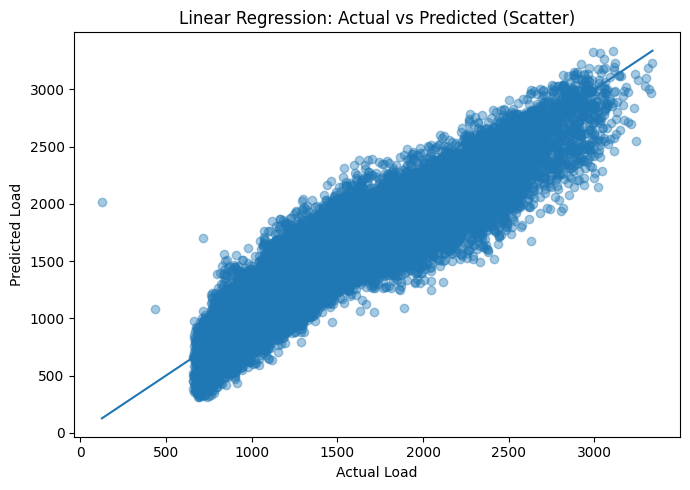

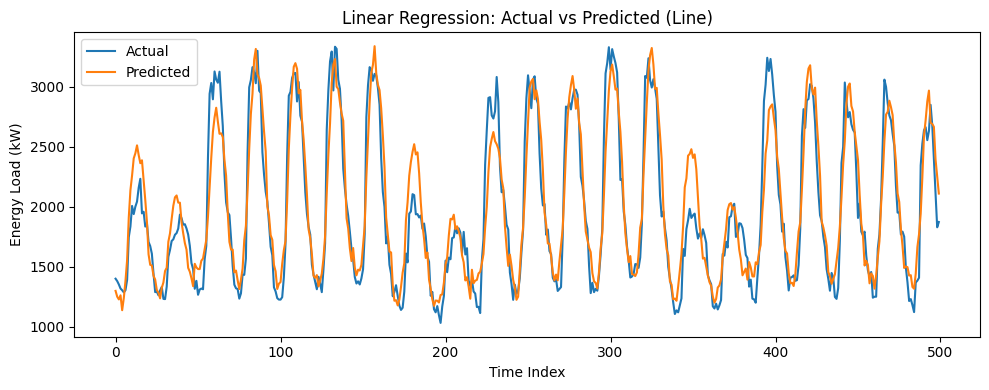

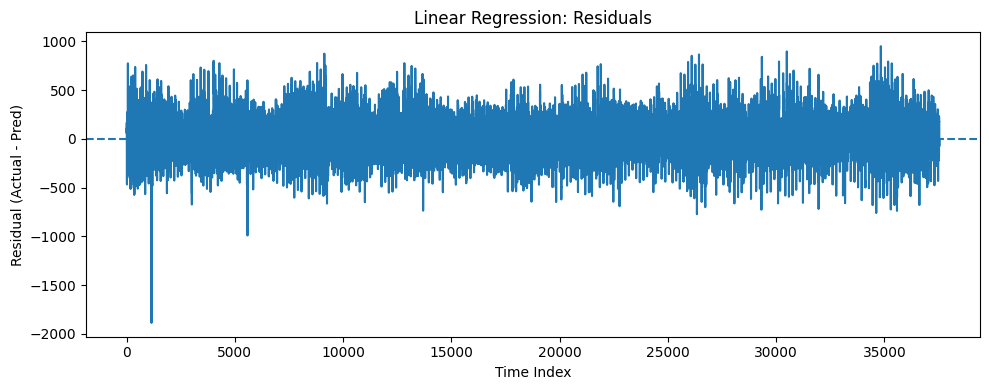

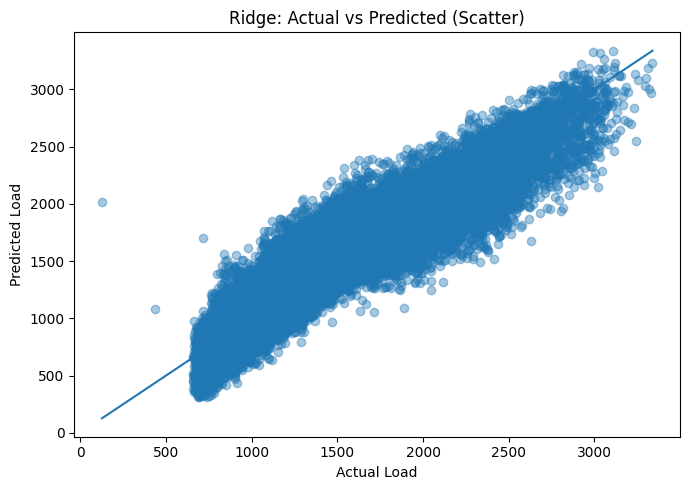

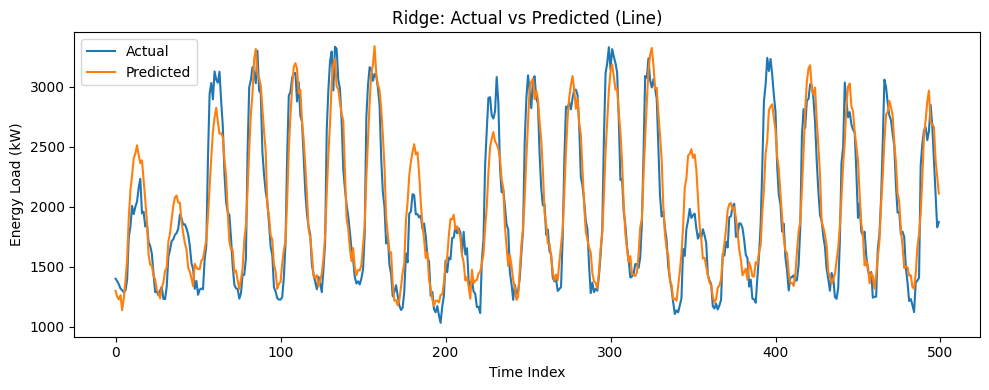

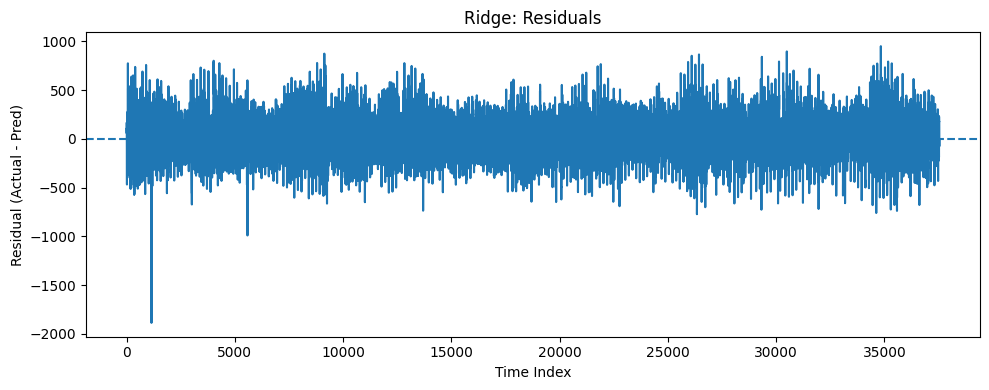

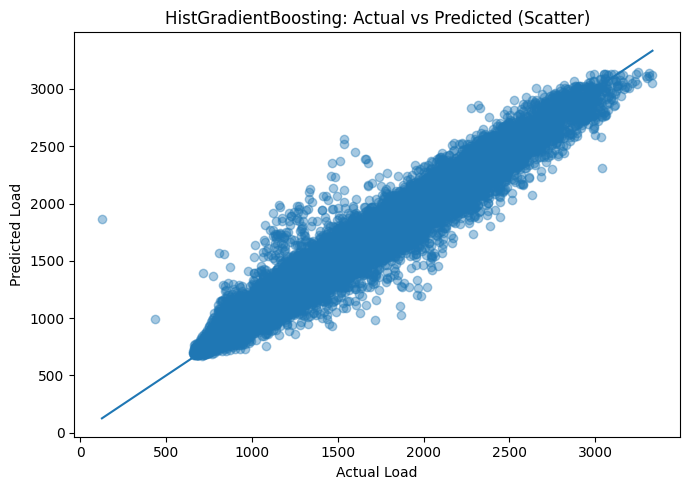

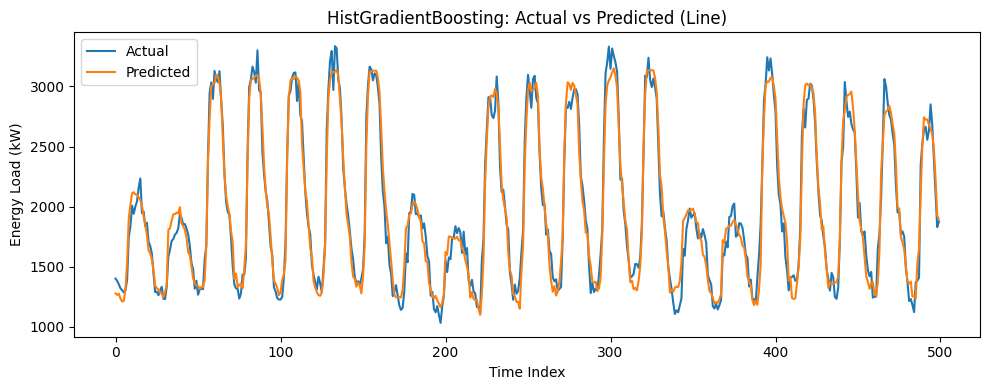

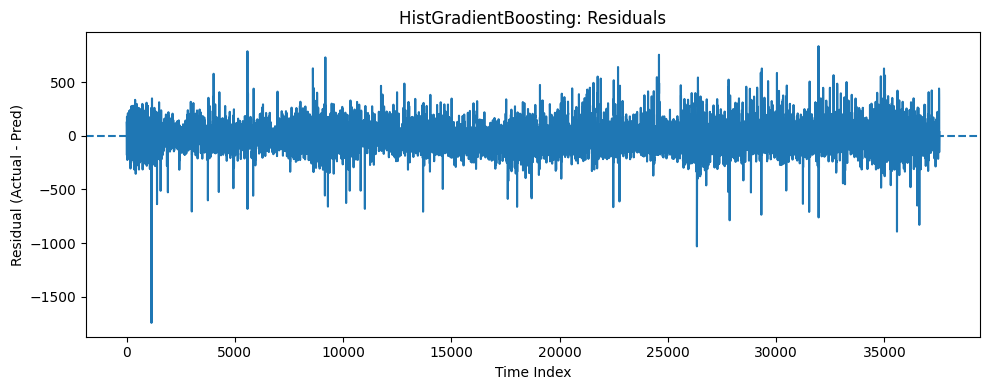

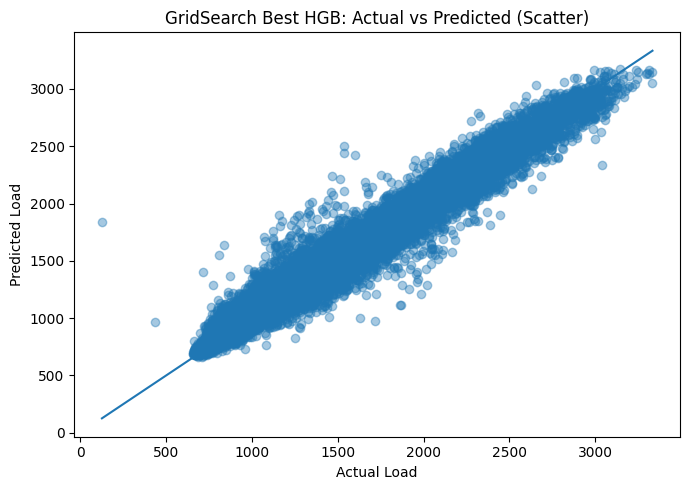

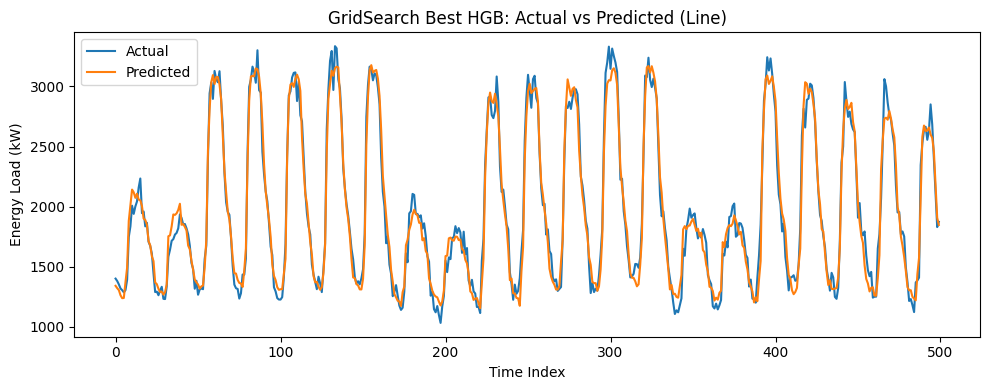

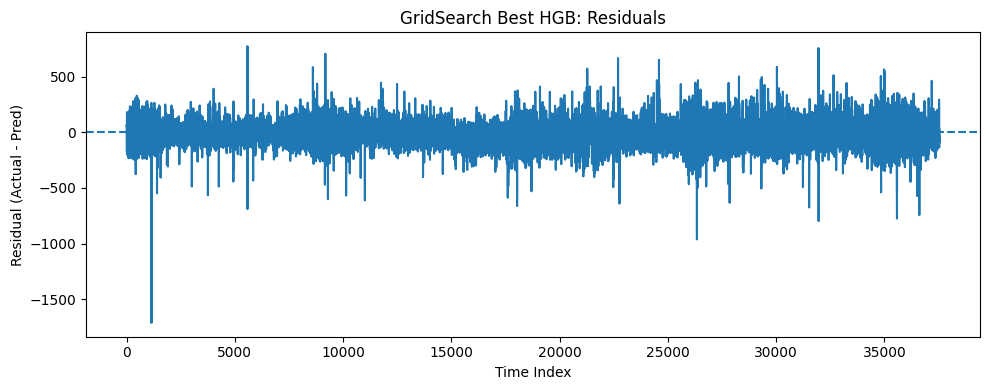

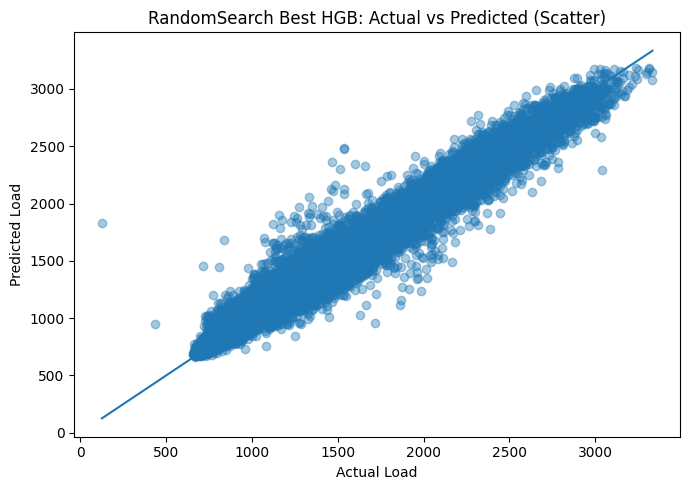

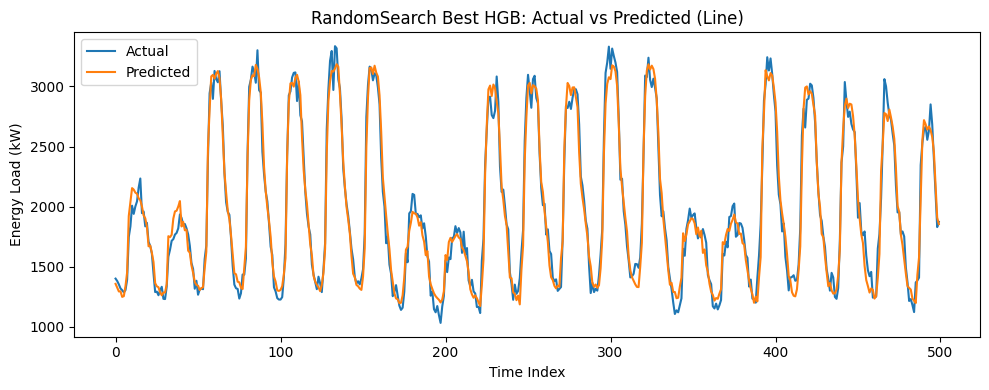

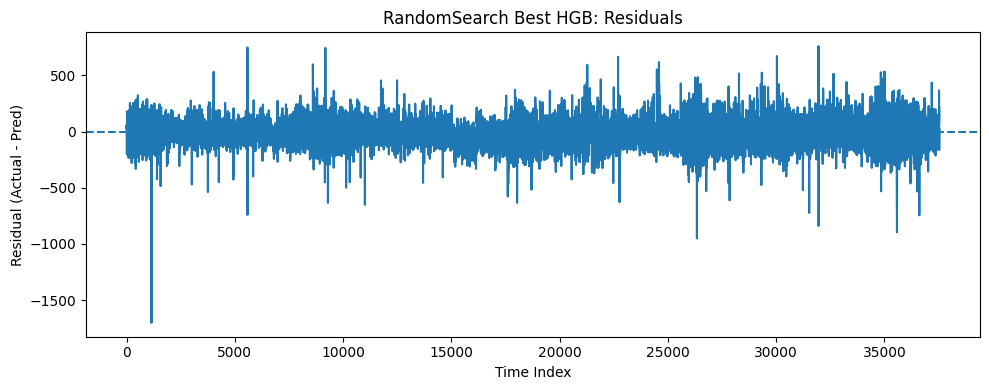

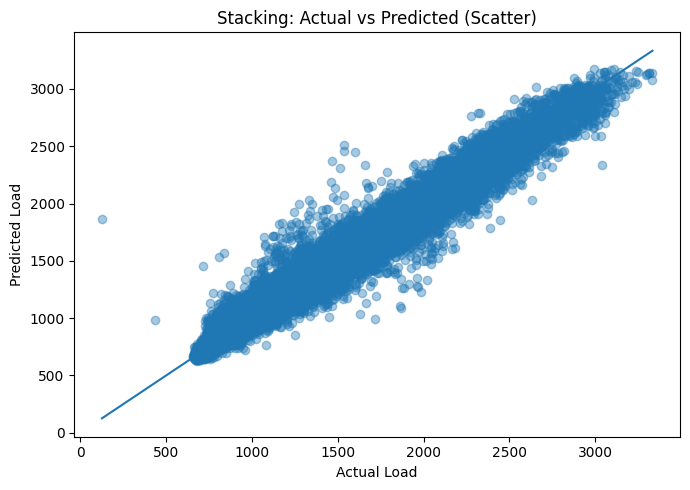

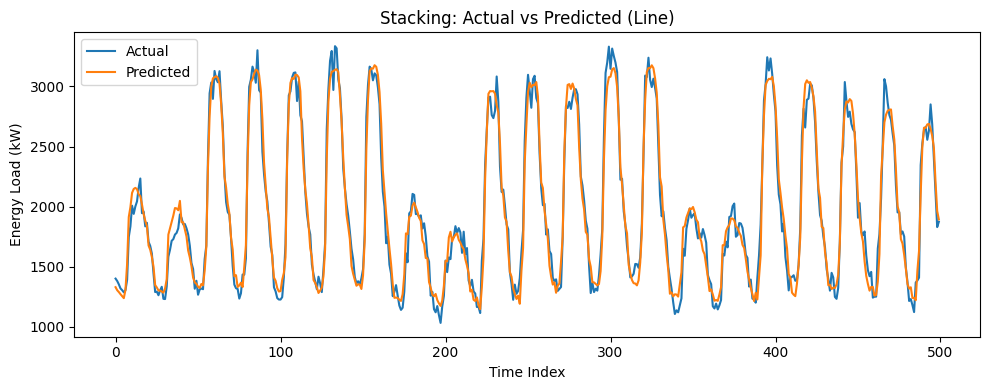

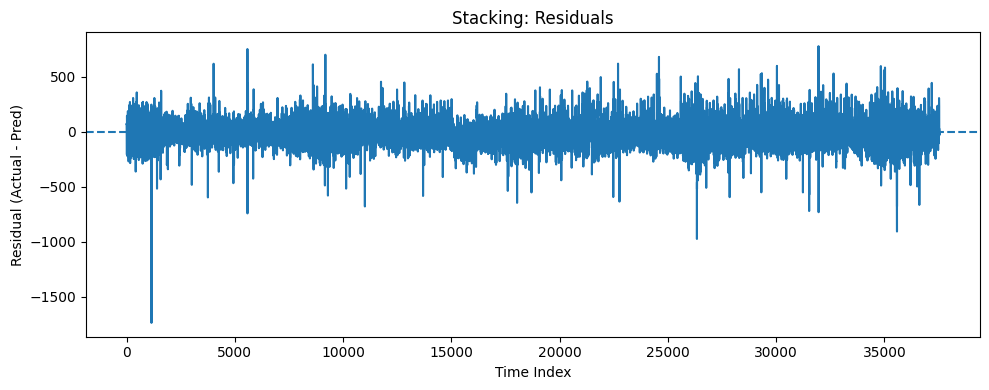

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance


# Metrics helper
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"Model": name, "RMSE": rmse, "MAE": mae, "R2": r2}


# Plot Actual vs Predicted (scatter)

def plot_actual_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(7,5))
    plt.scatter(y_true, y_pred, alpha=0.4)
    # perfect line
    line_min = min(y_true.min(), y_pred.min())
    line_max = max(y_true.max(), y_pred.max())
    plt.plot([line_min, line_max], [line_min, line_max])
    plt.xlabel("Actual Load")
    plt.ylabel("Predicted Load")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Plot Actual vs Predicted 

def plot_actual_pred_line(y_true, y_pred, title, n_points=500):
    plt.figure(figsize=(10,4))
    y_true_plot = np.array(y_true)[:n_points]
    y_pred_plot = np.array(y_pred)[:n_points]
    plt.plot(y_true_plot, label="Actual")
    plt.plot(y_pred_plot, label="Predicted")
    plt.title(title)
    plt.xlabel("Time Index")
    plt.ylabel("Energy Load (kW)")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Residual plot

def plot_residuals(y_true, y_pred, title):
    residuals = np.array(y_true) - np.array(y_pred)
    plt.figure(figsize=(10,4))
    plt.plot(residuals, label="Residuals")
    plt.axhline(0, linestyle="--")
    plt.title(title)
    plt.xlabel("Time Index")
    plt.ylabel("Residual (Actual - Pred)")
    plt.tight_layout()
    plt.show()


# Feature importance

def plot_feature_importance(model, X_train, title, top_n=15):
    feature_names = X_train.columns

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
    else:
        perm = permutation_importance(
            model, X_train, y_train, n_repeats=5, random_state=42, n_jobs=-1
        )
        importances = perm.importances_mean

    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(top_n)

    plt.figure(figsize=(8,5))
    fi.sort_values().plot(kind="barh")
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


# Collect predictions in one place
pred_dict = {
    "Linear Regression": lr_pred,
    "Ridge": ridge_pred,
    "HistGradientBoosting": hgb_pred,
    "GridSearch Best HGB": best_pred,
    "RandomSearch Best HGB": rs_pred,
    "Stacking": stack_pred,
    # "XGBoost": xgb_pred,   # uncomment if you have it
}

all_results = pd.DataFrame({"Actual": y_test.values})
for name, pred in pred_dict.items():
    all_results[name] = pred
    all_results[name + "_Error"] = all_results["Actual"] - all_results[name]

display(all_results.head(10))


# Metrics table
metrics = []
for name, pred in pred_dict.items():
    metrics.append(evaluate_model(name, y_test, pred))

metrics_df = pd.DataFrame(metrics).sort_values("R2", ascending=False)
display(metrics_df)


# Run plots for each model

for name, pred in pred_dict.items():
    plot_actual_vs_pred(y_test, pred, f"{name}: Actual vs Predicted (Scatter)")
    plot_actual_pred_line(y_test, pred, f"{name}: Actual vs Predicted (Line)")
    plot_residuals(y_test, pred, f"{name}: Residuals")


# Feature importance plots


# GridSearchCV tuning plot 

def plot_gridsearch_scores(grid, param_name):
    results = pd.DataFrame(grid.cv_results_)
    plt.figure(figsize=(7,4))
    plt.plot(results[f"param_{param_name}"], results["mean_test_score"], marker="o")
    plt.title(f"GridSearchCV: mean CV R2 vs {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Mean CV R2")
    plt.tight_layout()
    plt.show()




### Energy Consumption Forecasting – Project Summary

This project focuses on forecasting short-term energy consumption for a smart-grid environment using a fully cleaned and feature-engineered dataset. The goal was to build machine-learning models capable of accurately predicting electricity demand by learning from historical consumption patterns, engineered time-based features, and available weather information. Reliable forecasting helps improve grid stability, prevent overloads, optimize power distribution, and support renewable energy integration.

The dataset underwent detailed validation before modeling. All datetime fields were properly converted, and no missing values remained in either the target or input variables. The target variable, TOTAL_ELECTRIC_LOAD_kW, represents the total combined electricity load that the system aims to forecast. Predictor variables came from several feature groups, including time-based features (hour, day of week, month, weekend indicators), cyclic encodings for hour and day cycles, lag features such as Lag_24h_Load to capture previous-day behavior, rolling averages, exponential weighted moving averages, weather features (when available), and building-level load components such as Building A and B load. Together, these predictors captured both short-term and long-term consumption behavior.

During exploratory data analysis, I studied target load distribution, hourly and daily seasonality, and temperature-load relationships. The data showed clear daily cycles, higher weekday consumption, and moderate influence from weather variables. A correlation heatmap revealed that lag features and cyclic encodings were highly informative. Rolling trends also highlighted load fluctuations and smoothed patterns. These insights guided the feature engineering strategy and ultimately improved model performance.

Feature engineering played a crucial role in improving predictability. Time components were extracted from the datetime column, cyclic encodings were created to represent repetitive hourly and weekly patterns, and lag features such as Lag_24h_Load were added to replicate daily behavior. Rolling averages and EWMA values were generated to help the model understand short-term volatility and gradual changes in load. Each feature was carefully validated to ensure correct shifts and window alignment.

The modeling workflow progressed from simple to advanced algorithms. The baseline model used a naive persistence approach, predicting load based on the previous day at the same hour. This provided a strong benchmark to beat. Linear Regression and Ridge Regression were evaluated next but showed clear underfitting because energy consumption patterns are highly nonlinear. Tree-based approaches, especially HistGradientBoostingRegressor, performed substantially better and captured complex relationships more effectively.

To further enhance performance, I performed hyperparameter tuning using RandomizedSearchCV, which explored a broad range of learning rate, depth, regularization, and iteration values. This resulted in a significantly improved model with better accuracy and more stable predictions compared to default configurations. Finally, I implemented a Stacking Regressor combining multiple models. Although stacking performed reasonably well overall, it struggled to predict high-load peak values and did not surpass the tuned boosting model.

Model evaluation included R², RMSE, MAE, actual-vs-predicted plots, and residual analysis. Linear models had the weakest performance, while HGB provided strong results. The RandomizedSearchCV-tuned model consistently achieved the most accurate forecasts, with the lowest error range (approximately 20–60 kW) and smooth predictions across all hours. The ensemble stacking model was helpful but not superior to the tuned boosting model.